In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from netpois import ctu_utils, constants, utils

2023-05-23 12:26:33.370413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 12:26:36.610023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64::/home/giorgioseveri/.local/lib
2023-05-23 12:26:36.610314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64::/home/giorgioseveri/.local/lib
2023-05-23 1

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Conn log files

In [9]:
conn_log_1_42 = pd.read_csv('/net/data/netpois/ctu-13/1_42/conn_log.csv')
conn_log_2_43 = pd.read_csv('/net/data/netpois/ctu-13/2_43/conn_log.csv')
conn_log_9_50 = pd.read_csv('/net/data/netpois/ctu-13/9_50/conn_log.csv')

In [10]:
print("Total number of connection events: {}".format(
    conn_log_1_42.shape[0] + conn_log_2_43.shape[0] + conn_log_9_50.shape[0])
)

Total number of connection events: 9261973


In [5]:
# train_csvs = [
#     "/net/data/netpois/ctu-13/supervised/data/1_42/neris/window_30/features_stat.csv",
#     "/net/data/netpois/ctu-13/supervised/data/2_43/neris/window_30/features_stat.csv",
# ]
# test_csvs = [
#     "/net/data/netpois/ctu-13/supervised/data/9_50/neris/window_30/features_stat.csv",
# ]
# aggr_feats_trn = []
# aggr_feats_tst = []
# for csv in train_csvs:
#     aggr_feats_trn.append(pd.read_csv(csv))
# for csv in test_csvs:
#     aggr_feats_tst.append(pd.read_csv(csv))

# aggr_feats_trn_sizes = [df.shape[0] for df in aggr_feats_trn]
# aggr_feats_tst_sizes = [df.shape[0] for df in aggr_feats_tst]

# print("Total aggregated points: {}".format(
#     sum(aggr_feats_trn_sizes) + sum(aggr_feats_tst_sizes)
# ))

In [6]:
def clean_conn_log(conn_log: pd.DataFrame):
    # Remove internal connections
    (
        conn_log_int_ips,
        conn_log_missing,
        conn_log_int_to_int,
    ) = ctu_utils.find_internal_ip(conn_log)
    conn_log_missing_and_int_to_int = np.union1d(conn_log_missing, conn_log_int_to_int)
    conn_log_cln = conn_log.drop(
        conn_log.index[conn_log_missing_and_int_to_int]
    )

    # Replace all '-' with 0
    conn_log_cln = conn_log_cln.replace("-", 0)
    conn_log_cln = conn_log_cln.drop(columns=["ts", "uid", "id.orig_h", "id.resp_h"])

    # Factorize categorical features
    to_factorize = ["proto", "service", "conn_state"]
    for col in to_factorize:
        conn_log_cln[col] = pd.factorize(conn_log_cln[col])[0]

    # Set all remaining features to float
    conn_log_cln = conn_log_cln.astype(float)

    return conn_log_cln


def get_corr_cov(conn_log_id: str, conn_log: pd.DataFrame):
    conn_log_labeled = ctu_utils.label_conn_log(conn_log_id, conn_log)

    # Remove internal connections
    (
        conn_log_int_ips,
        conn_log_missing,
        conn_log_int_to_int,
    ) = ctu_utils.find_internal_ip(conn_log_labeled)
    conn_log_missing_and_int_to_int = np.union1d(conn_log_missing, conn_log_int_to_int)
    conn_log_cln = conn_log_labeled.drop(
        conn_log_labeled.index[conn_log_missing_and_int_to_int]
    )

    # Replace all '-' with 0
    conn_log_cln = conn_log_cln.replace("-", 0)
    conn_log_cln = conn_log_cln.drop(columns=["ts", "uid", "id.orig_h", "id.resp_h"])

    # Factorize categorical features
    to_factorize = ["proto", "service", "conn_state"]
    for col in to_factorize:
        conn_log_cln[col] = pd.factorize(conn_log_cln[col])[0]

    # Set all remaining features to float
    conn_log_cln = conn_log_cln.astype(float)

    # Compute pairwise correlation of columns
    conn_log_cln_corr = conn_log_cln.corr(numeric_only=True)

    # Comupute covariance matrix
    conn_log_cln_cov = conn_log_cln.cov(numeric_only=True)

    return conn_log_cln_corr, conn_log_cln_cov


def plot_corr_cov(conn_log_id, conn_log_cln_corr, conn_log_cln_cov):
    sns.set()
    # Plot both the heatmaps
    # Make figure big enough for all the labels
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plot the correlation matrix
    sns.heatmap(
        conn_log_cln_corr,
        xticklabels=conn_log_cln_corr.columns,
        yticklabels=conn_log_cln_corr.columns,
        cmap="rocket_r",
        annot=True,
        linewidth=0.5,
        fmt=".2f",
        ax=ax1,
    )
    ax1.hlines([10], *ax1.get_xlim(), linewidth=2.5)
    ax1.vlines([10], *ax1.get_ylim(), linewidth=2.5)

    # Plot the covariance matrix
    sns.heatmap(
        conn_log_cln_cov,
        xticklabels=conn_log_cln_cov.columns,
        yticklabels=conn_log_cln_cov.columns,
        cmap="rocket_r",
        # annot=True,
        linewidth=0.5,
        fmt=".3g",
        ax=ax2,
    )
    ax2.hlines([10], *ax2.get_xlim(), linewidth=2.5)
    ax2.vlines([10], *ax2.get_ylim(), linewidth=2.5)

    # Set the title
    ax1.set_title("Correlation matrix for {}".format(conn_log_id))
    ax2.set_title("Covariance matrix for {}".format(conn_log_id))

    plt.tight_layout()
    plt.show()


## Covariances

In [14]:
conn_log_1_42_corr, conn_log_1_42_cov = get_corr_cov("1_42", conn_log_1_42)
conn_log_2_43_corr, conn_log_2_43_cov = get_corr_cov("2_43", conn_log_2_43)
conn_log_9_50_corr, conn_log_9_50_cov = get_corr_cov("9_50", conn_log_9_50)

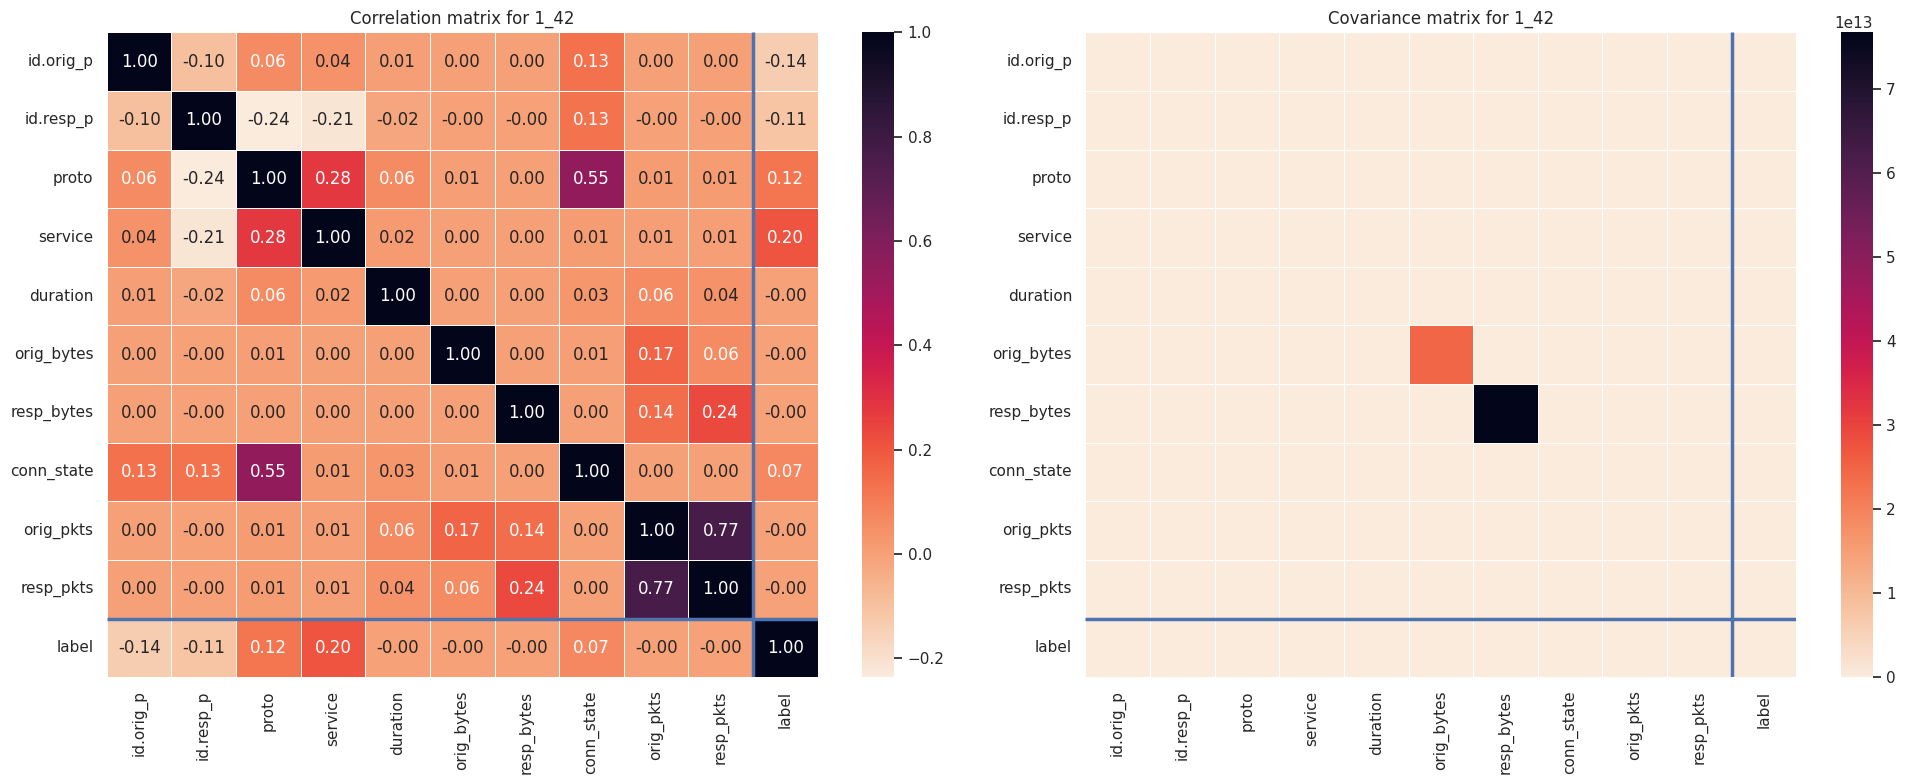

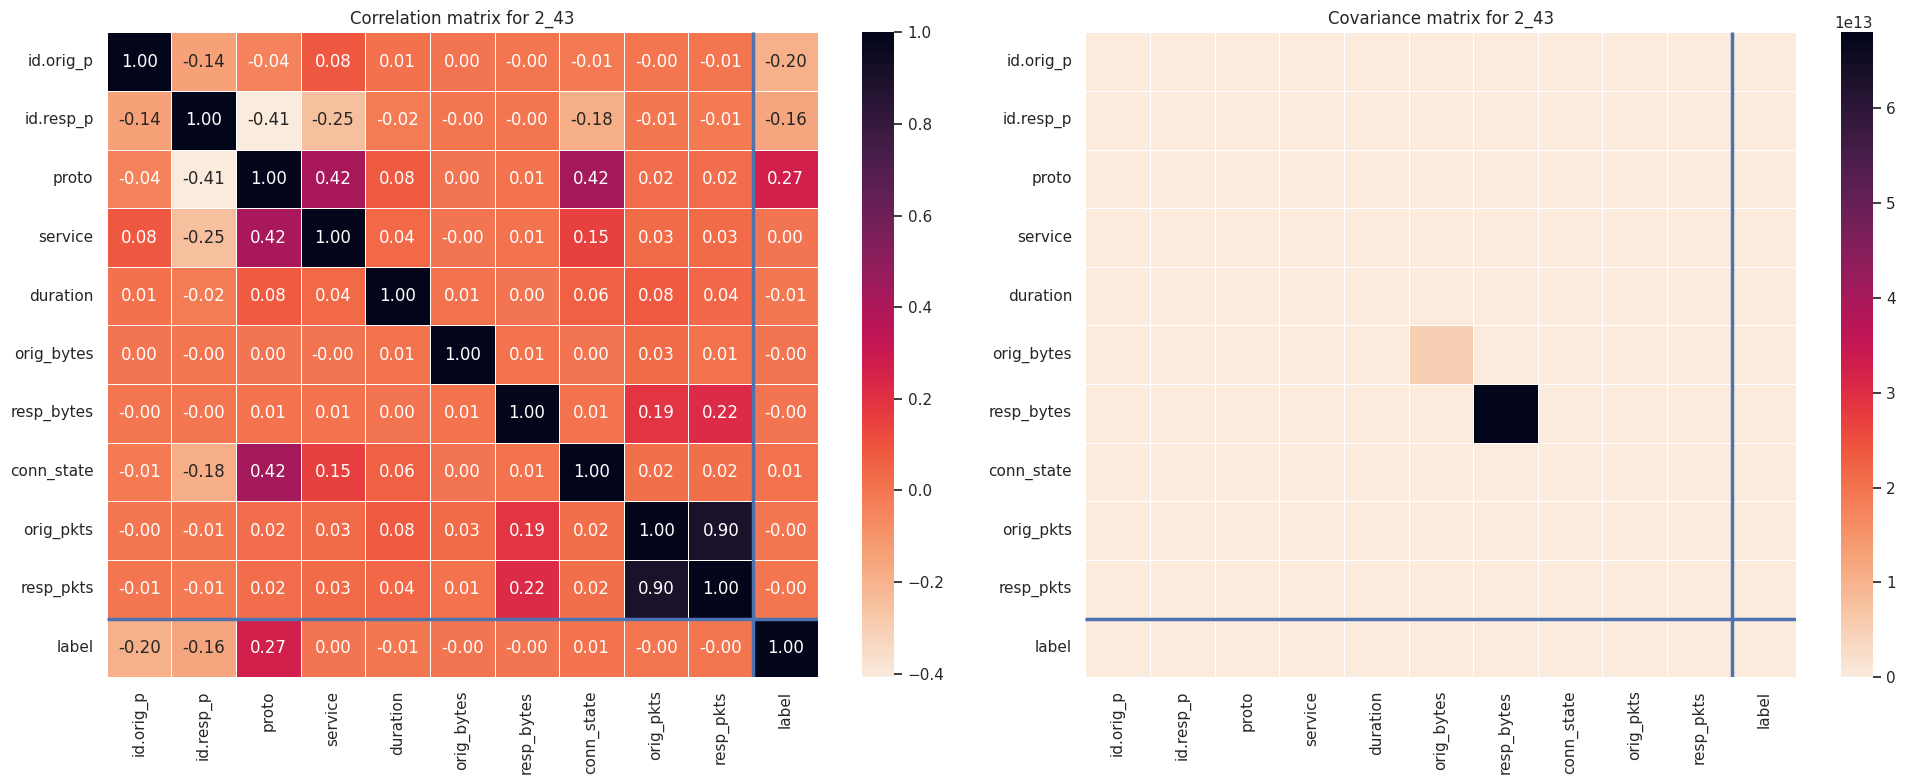

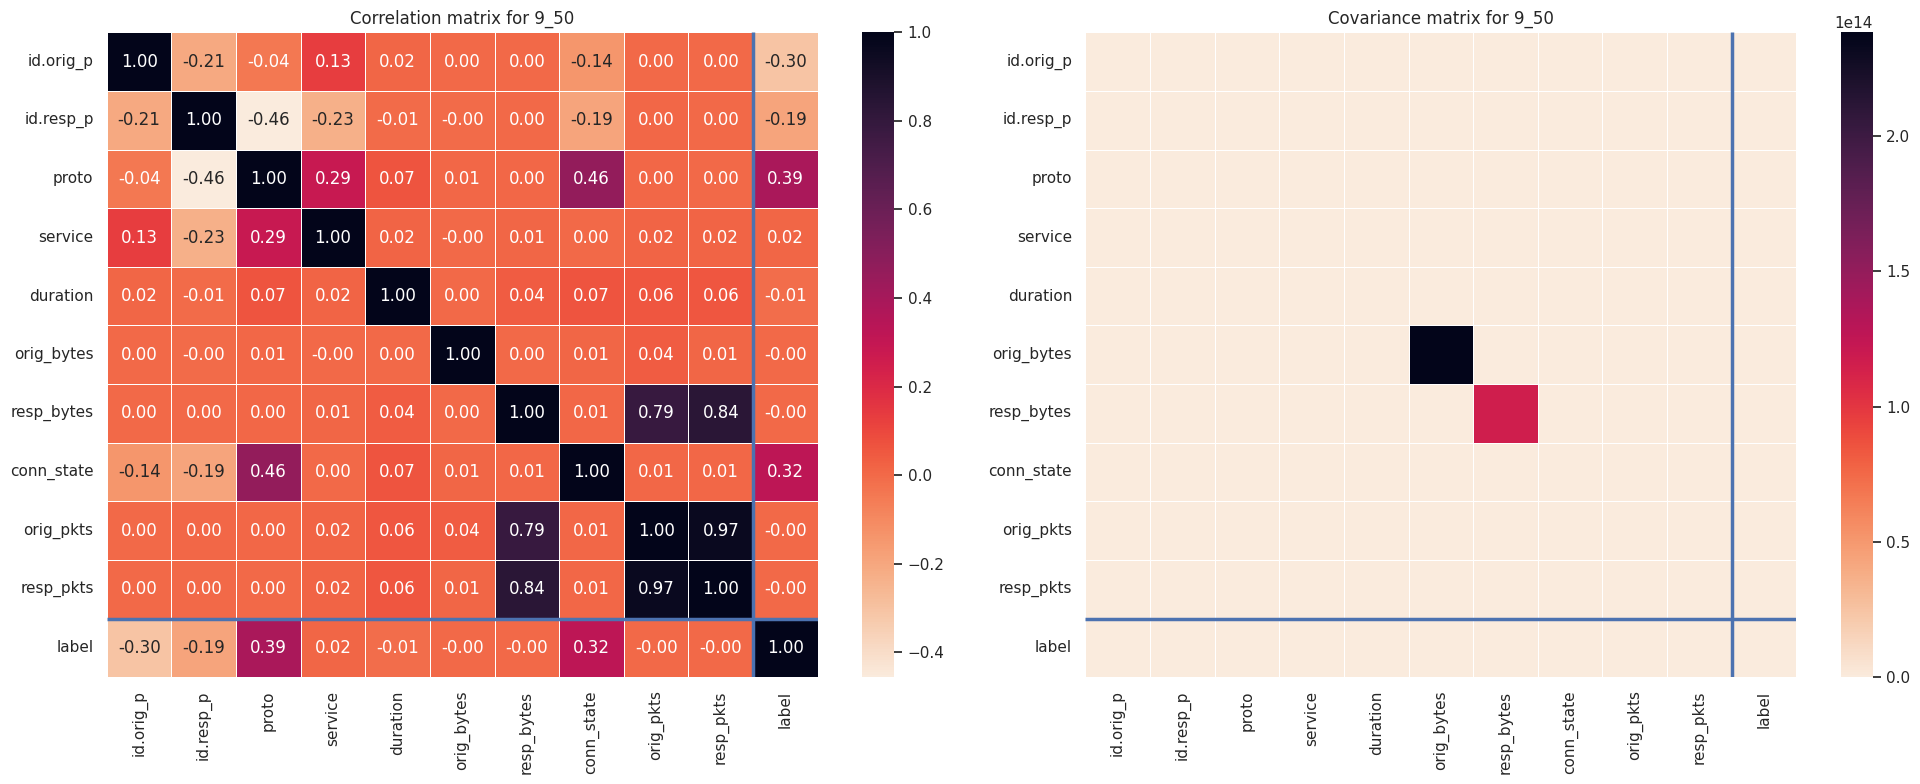

In [15]:
plot_corr_cov("1_42", conn_log_1_42_corr, conn_log_1_42_cov)
plot_corr_cov("2_43", conn_log_2_43_corr, conn_log_2_43_cov)
plot_corr_cov("9_50", conn_log_9_50_corr, conn_log_9_50_cov)

In [11]:
conn_log_9_50

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,orig_pkts,resp_pkts
0,1.313575e+09,CfSosP1O7zZdD9CKYc,188.75.133.98,16200,147.32.86.125,35248,udp,-,4319.726686,191012435,17756933,SF,235581,204835
1,1.313575e+09,CXCYCAnaDS25pXv32,119.252.172.92,59067,147.32.84.14,80,tcp,-,2059.387394,0,252712860,RSTOS0,50389,173886
2,1.313575e+09,CivplW23FeR6skH1f7,147.32.86.89,1176,90.183.101.168,80,tcp,-,14.996537,0,2677,SF,3,5
3,1.313575e+09,CIyRY94Y7zTN7FOVL1,217.169.177.82,56950,147.32.85.26,54145,tcp,-,28.917550,5723,5237918,RSTOS0,2153,3868
4,1.313575e+09,CZTaYZ2qhV0shfAht7,119.252.172.92,59066,147.32.84.14,80,tcp,-,2021.743558,0,269314520,RSTOS0,53562,185428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625787,1.313594e+09,CpBRrN1zTTeNWMC1k4,188.195.16.24,11613,147.32.84.229,13363,udp,-,0.000656,32,18,SF,1,1
2625788,1.313594e+09,C22Xfr2hpWpAgauBM9,147.32.86.20,53659,147.32.80.9,53,udp,dns,0.000466,43,136,SF,1,1
2625789,1.313594e+09,CwP9uD3ezs89j4uNHk,147.32.86.20,3499,188.138.84.239,80,tcp,http,0.077026,141,2920,S1,5,5
2625790,1.313594e+09,CR6iMh107NaiZCJbkf,87.121.84.142,23139,147.32.86.165,12114,udp,-,-,-,-,S0,1,0


In [10]:
test = conn_log_9_50[conn_log_9_50["resp_bytes"] == "0"]
display(test)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,orig_pkts,resp_pkts
8,1.313575e+09,CZ8E2S13vKQDt5mhCc,147.32.84.118,3926,151.54.127.34,6881,tcp,-,0.096906,0,0,REJ,1,1
23,1.313575e+09,CjRWca3fRvhyJE7b78,147.32.84.59,49968,147.32.193.19,80,tcp,-,0.001596,0,0,SHR,1,1
27,1.313575e+09,CDuarV19cBrpx8umCd,89.235.37.130,8,147.32.84.122,0,icmp,-,18.069712,1064,0,OTH,19,0
47,1.313575e+09,C7hEPw2btAmju4dzgl,147.32.84.59,49969,147.32.193.19,80,tcp,-,0.002309,0,0,SHR,1,1
62,1.313575e+09,CGZYPh15dhJQBumykf,121.240.99.166,500,147.32.86.165,500,udp,-,0.000234,624,0,S0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625728,1.313594e+09,CWDdFA3wjqSbrUZ7c4,86.49.87.107,3,147.32.84.215,1,icmp,-,0.012902,56,0,OTH,2,0
2625735,1.313594e+09,Cv7HIm2hwQhKZxzCba,88.96.193.1,34127,147.32.84.229,443,tcp,-,0.000210,0,0,S1,1,1
2625744,1.313594e+09,Cl011o16v0MJBtkHog,88.23.178.21,50014,147.32.84.118,6881,tcp,-,0.000197,0,0,REJ,1,1
2625752,1.313594e+09,CbElGq1FInwW5jDA2g,46.20.209.224,6881,147.32.84.118,3792,tcp,-,0.000163,4,0,RSTRH,1,1


In [8]:
test[test["orig_bytes"] == "0"]

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,orig_pkts,resp_pkts
2,1.313575e+09,CivplW23FeR6skH1f7,147.32.86.89,1176,90.183.101.168,80,tcp,-,14.996537,0,2677,SF,3,5
7,1.313575e+09,Cy5wODlLJ3LZEDmYh,147.32.85.88,61743,147.32.80.13,80,tcp,-,3397.838446,0,54375372,SF,34160,60559
14,1.313575e+09,CuEr8R1UMopCRkohvc,147.32.84.59,60041,69.147.83.197,80,tcp,-,0.685620,0,69961,SF,30,50
15,1.313575e+09,CuS52IOXuRUoWvmQ7,88.176.79.163,51932,147.32.84.172,50417,tcp,-,696.409260,0,337252680,SF,121423,233749
36,1.313575e+09,CCTjbhVCNg85HoJCl,147.32.84.59,49730,67.195.186.236,80,tcp,-,0.002588,0,602,SF,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623685,1.313594e+09,CXK4Xn4LwTG1HFVOyi,147.32.86.141,2337,69.63.190.10,80,tcp,-,19.924514,0,0,SF,4,3
2624537,1.313594e+09,CFHigU2TqjRlr4T1ye,147.32.84.170,52695,209.85.148.104,80,tcp,-,0.018623,0,0,SF,4,2
2624799,1.313594e+09,CRWdL13uW8a6MMIN67,109.80.67.66,29333,147.32.84.2,80,tcp,-,5.219116,0,0,SF,4,3
2625427,1.313594e+09,Cl4jZyjoYRhicnojk,147.32.84.170,53112,209.85.148.106,80,tcp,-,0.018777,0,0,SF,4,2


## Finding the best distribution for the bytes

In [7]:
# from pomegranate import BayesianNetwork
# This crashes the kernel
# model = BayesianNetwork.from_samples(conn_log_1_42_cln.values, algorithm='exact')

In [7]:
conn_log_1_42_cln = clean_conn_log(conn_log_1_42)
display(conn_log_1_42_cln)

# Randomly sample 15% of the data
conn_log_1_42_cln = conn_log_1_42_cln.sample(frac=0.15, random_state=42)
print(conn_log_1_42_cln.shape)

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,orig_pkts,resp_pkts
0,39678.0,13363.0,0.0,0.0,0.000823,32.0,18.0,0.0,1.0,1.0
1,28431.0,13363.0,0.0,0.0,0.000883,33.0,18.0,0.0,1.0,1.0
2,2063.0,80.0,1.0,0.0,0.000326,0.0,0.0,1.0,1.0,1.0
3,32882.0,21857.0,1.0,0.0,0.000154,0.0,0.0,0.0,2.0,1.0
4,21278.0,13363.0,0.0,0.0,0.001000,34.0,18.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
4070894,60122.0,13363.0,0.0,0.0,0.000935,33.0,422.0,0.0,1.0,1.0
4070895,47077.0,13754.0,1.0,0.0,0.000000,0.0,0.0,3.0,1.0,0.0
4070896,38516.0,13363.0,0.0,0.0,0.000000,0.0,0.0,3.0,1.0,0.0
4070897,10520.0,13363.0,0.0,0.0,0.002618,418.0,17.0,0.0,1.0,1.0


(464750, 10)


In [8]:
resp_pkts = conn_log_1_42_cln["resp_pkts"].astype(float).to_numpy()
resp_bytes = conn_log_1_42_cln["resp_bytes"].astype(float).to_numpy()
assert resp_bytes.shape == resp_pkts.shape

print("Min val packets: {}".format(resp_pkts.min()))
print("Max val packets: {}".format(resp_pkts.max()))
print("Avg val packets: {}".format(resp_pkts.mean()))
print("Std val packets: {}".format(resp_pkts.std()))
print("Min val bytes: {}".format(resp_bytes.min()))
print("Max val bytes: {}".format(resp_bytes.max()))
print("Avg val bytes: {}".format(resp_bytes.mean()))
print("Std val bytes: {}".format(resp_bytes.std()))

# Compute the average number of bytes per packet
resp_bytes_per_pkt = resp_bytes / (resp_pkts + 1)
print("Min val bytes per packet: {}".format(resp_bytes_per_pkt.min()))
print("Max val bytes per packet: {}".format(resp_bytes_per_pkt.max()))
print("Avg val bytes per packet: {}".format(resp_bytes_per_pkt.mean()))
print("Std val bytes per packet: {}".format(resp_bytes_per_pkt.std()))

# Find the index of the largest bytes per packet
# max_idx = np.argmax(resp_bytes_per_pkt)
# display(conn_log_1_42.iloc[conn_log_1_42_cln.iloc[max_idx].name])
# There is a connection with 4 response packets, and 10GB of data 
# We need to aggressively filter outlier0s


# Similarly for the originator
orig_pkts = conn_log_1_42_cln["orig_pkts"].astype(float).to_numpy()
orig_bytes = conn_log_1_42_cln["orig_bytes"].astype(float).to_numpy()
assert orig_bytes.shape == orig_pkts.shape

print("Min val packets: {}".format(orig_pkts.min()))
print("Max val packets: {}".format(orig_pkts.max()))
print("Avg val packets: {}".format(orig_pkts.mean()))
print("Std val packets: {}".format(orig_pkts.std()))
print("Min val bytes: {}".format(orig_bytes.min()))
print("Max val bytes: {}".format(orig_bytes.max()))
print("Avg val bytes: {}".format(orig_bytes.mean()))
print("Std val bytes: {}".format(orig_bytes.std()))

# Compute the average number of bytes per packet
orig_bytes_per_pkt = orig_bytes / (orig_pkts + 1)
print("Min val bytes per packet: {}".format(orig_bytes_per_pkt.min()))
print("Max val bytes per packet: {}".format(orig_bytes_per_pkt.max()))
print("Avg val bytes per packet: {}".format(orig_bytes_per_pkt.mean()))
print("Std val bytes per packet: {}".format(orig_bytes_per_pkt.std()))


Min val packets: 0.0
Max val packets: 678678.0
Avg val packets: 11.63154384077461
Std val packets: 1259.099660857351
Min val bytes: 0.0
Max val bytes: 10424498597.0
Avg val bytes: 35100.68476600323
Std val bytes: 15381701.828943789
Min val bytes per packet: 0.0
Max val bytes per packet: 2084899719.4
Avg val bytes per packet: 4996.020622351159
Std val bytes per packet: 3065420.4516277416
Min val packets: 0.0
Max val packets: 1287818.0
Avg val packets: 9.946786444324905
Std val packets: 1950.8671567140912
Min val bytes: 0.0
Max val bytes: 1844175440.0
Avg val bytes: 28641.884667025282
Std val bytes: 6074137.513089288
Min val bytes per packet: 0.0
Max val bytes per packet: 850484656.5
Avg val bytes per packet: 9181.826332851515
Std val bytes per packet: 2271625.7791988635


In [9]:
# Filter out the outliers by removing all values in the top 99.9th percentile
resp_bytes_per_pkt = resp_bytes_per_pkt[resp_bytes_per_pkt < np.percentile(resp_bytes_per_pkt, 99.9)]
print("Num values removed: {}".format(resp_pkts.shape[0] - resp_bytes_per_pkt.shape[0]))
print("Min val bytes per packet: {}".format(resp_bytes_per_pkt.min()))
print("Max val bytes per packet: {}".format(resp_bytes_per_pkt.max()))
print("Avg val bytes per packet: {}".format(resp_bytes_per_pkt.mean()))
print("Std val bytes per packet: {}".format(resp_bytes_per_pkt.std()))
# Similarly for the originator
orig_bytes_per_pkt = orig_bytes_per_pkt[orig_bytes_per_pkt < np.percentile(orig_bytes_per_pkt, 99.9)]
print("Num values removed: {}".format(orig_pkts.shape[0] - orig_bytes_per_pkt.shape[0]))
print("Min val bytes per packet: {}".format(orig_bytes_per_pkt.min()))
print("Max val bytes per packet: {}".format(orig_bytes_per_pkt.max()))
print("Avg val bytes per packet: {}".format(orig_bytes_per_pkt.mean()))
print("Std val bytes per packet: {}".format(orig_bytes_per_pkt.std()))

Num values removed: 465
Min val bytes per packet: 0.0
Max val bytes per packet: 1372.5238095238096
Avg val bytes per packet: 78.91650164218564
Std val bytes per packet: 191.93750100344388
Num values removed: 465
Min val bytes per packet: 0.0
Max val bytes per packet: 516.0403225806451
Avg val bytes per packet: 44.63145963893679
Std val bytes per packet: 61.22180870249973


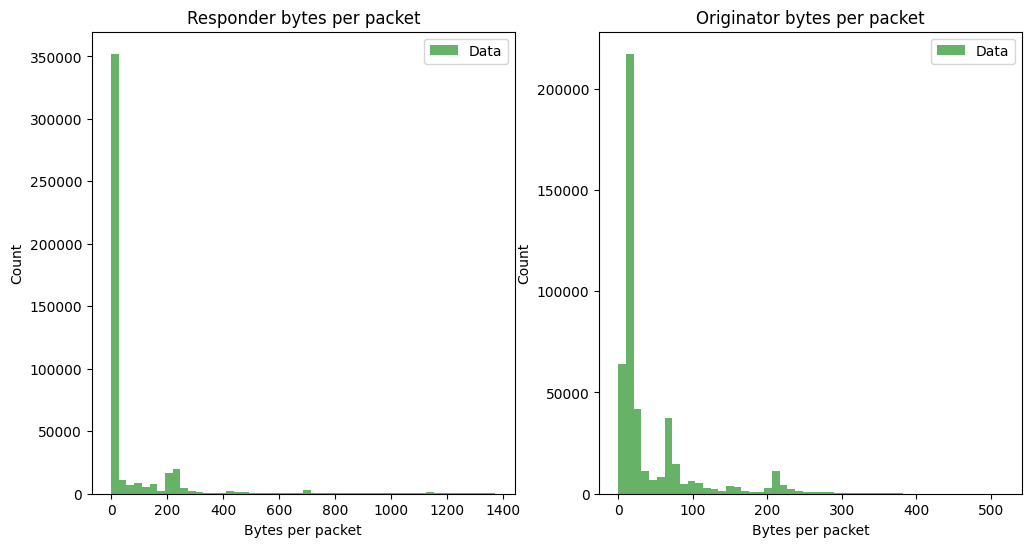

Resp - Number of zero average bytes per packet 70666
Resp - Total observations 464285
Resp - Percentage of zero average bytes per packet 0.1522039264675792
Orig - Number of zero average bytes per packet 53000
Orig - Total observations 464285
Orig - Percentage of zero average bytes per packet 0.11415402177541811


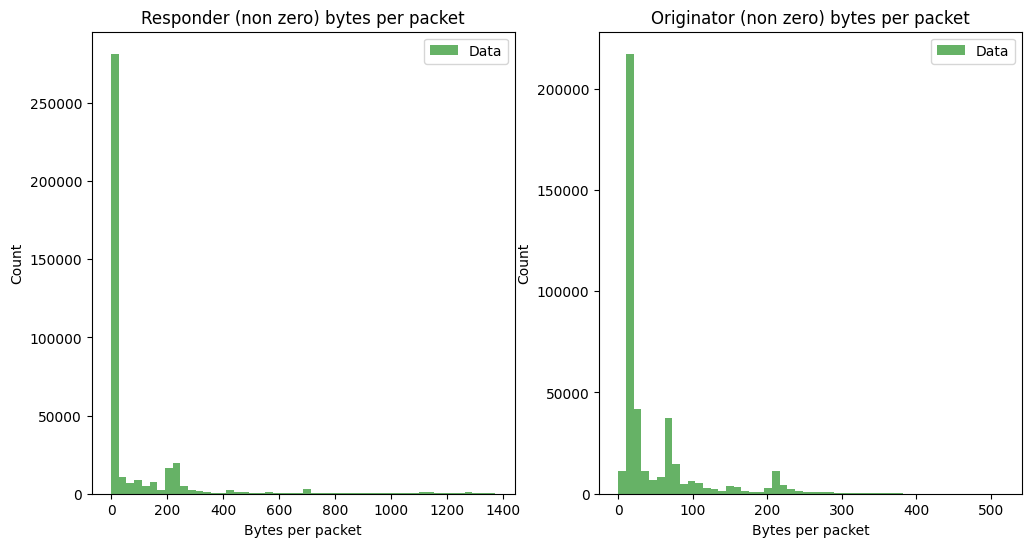

In [10]:
# Plot the histogram of bytes per packet for the responder and originator side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(resp_bytes_per_pkt, bins=50, density=False, alpha=0.6, color='g', label='Data')
ax1.set_title("Responder bytes per packet")
ax1.set_xlabel("Bytes per packet")
ax1.set_ylabel("Count")
ax1.legend()
ax2.hist(orig_bytes_per_pkt, bins=50, density=False, alpha=0.6, color='g', label='Data')
ax2.set_title("Originator bytes per packet")
ax2.set_xlabel("Bytes per packet")
ax2.set_ylabel("Count")
ax2.legend()
plt.show()

print("Resp - Number of zero average bytes per packet", sum(resp_bytes_per_pkt == 0))
print("Resp - Total observations", resp_bytes_per_pkt.shape[0])
print("Resp - Percentage of zero average bytes per packet", sum(resp_bytes_per_pkt == 0) / resp_bytes_per_pkt.shape[0])
print("Orig - Number of zero average bytes per packet", sum(orig_bytes_per_pkt == 0))   
print("Orig - Total observations", orig_bytes_per_pkt.shape[0])
print("Orig - Percentage of zero average bytes per packet", sum(orig_bytes_per_pkt == 0) / orig_bytes_per_pkt.shape[0])

# Removing the zero values
resp_bytes_per_pkt_nz = resp_bytes_per_pkt[resp_bytes_per_pkt != 0]
orig_bytes_per_pkt_nz = orig_bytes_per_pkt[orig_bytes_per_pkt != 0]

# Plot the histogram of bytes per packet for the responder and originator side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(resp_bytes_per_pkt_nz, bins=50, density=False, alpha=0.6, color='g', label='Data')
ax1.set_title("Responder (non zero) bytes per packet")
ax1.set_xlabel("Bytes per packet")
ax1.set_ylabel("Count")
ax1.legend()
ax2.hist(orig_bytes_per_pkt_nz, bins=50, density=False, alpha=0.6, color='g', label='Data')
ax2.set_title("Originator (non zero) bytes per packet")
ax2.set_xlabel("Bytes per packet")
ax2.set_ylabel("Count")
ax2.legend()
plt.show()

### Gaussian

In [11]:
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

# Fit a normal distribution to the data:
resp_bytes_per_pkt_mu, resp_bytes_per_pkt_std = norm.fit(resp_bytes_per_pkt)
print("Mean: {}".format(resp_bytes_per_pkt_mu))
print("Std: {}".format(resp_bytes_per_pkt_std))
# Similarly for the originator
orig_bytes_per_pkt_mu, orig_bytes_per_pkt_std = norm.fit(orig_bytes_per_pkt)
print("Mean: {}".format(orig_bytes_per_pkt_mu))
print("Std: {}".format(orig_bytes_per_pkt_std))

Mean: 78.91650164218564
Std: 191.93750100344388
Mean: 44.63145963893679
Std: 61.22180870249973


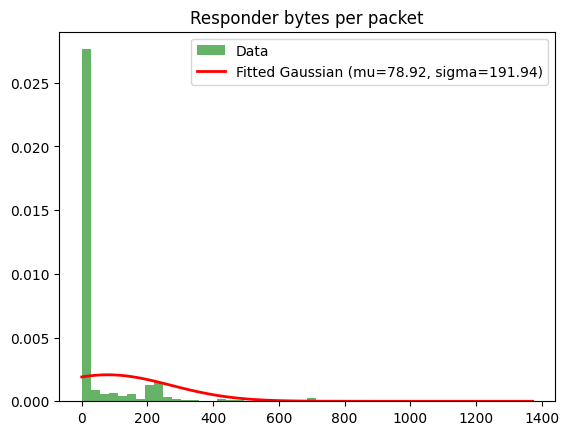

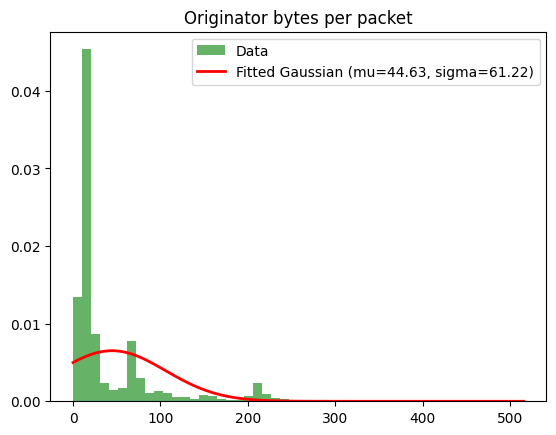

In [12]:
plt.hist(resp_bytes_per_pkt, bins=50, density=True, alpha=0.6, color='g', label='Data')

# Generate the PDF of the fitted Gaussian
x = np.linspace(np.min(resp_bytes_per_pkt), np.max(resp_bytes_per_pkt), 100)
fitted_pdf = norm.pdf(x, resp_bytes_per_pkt_mu, resp_bytes_per_pkt_std)

# Plot the fitted Gaussian PDF
plt.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Gaussian (mu={resp_bytes_per_pkt_mu:.2f}, sigma={resp_bytes_per_pkt_std:.2f})')
plt.title("Responder bytes per packet")
# Add a legend and display the plot
plt.legend()
plt.show()

plt.hist(orig_bytes_per_pkt, bins=50, density=True, alpha=0.6, color='g', label='Data')

# Generate the PDF of the fitted Gaussian
x = np.linspace(np.min(orig_bytes_per_pkt), np.max(orig_bytes_per_pkt), 100)
fitted_pdf = norm.pdf(x, orig_bytes_per_pkt_mu, orig_bytes_per_pkt_std)

# Plot the fitted Gaussian PDF
plt.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Gaussian (mu={orig_bytes_per_pkt_mu:.2f}, sigma={orig_bytes_per_pkt_std:.2f})')
plt.title("Originator bytes per packet")
# Add a legend and display the plot
plt.legend()
plt.show()



### Various distributions

In [33]:
from distfit import distfit

dfit = distfit(todf=True)

# Fit the responder bytes per packet
resp_dfit = dfit.fit_transform(resp_bytes_per_pkt)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.882095] [loc=78.917 scale=191.938]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.858765] [loc=0.000 scale=78.917]
[distfit] >INFO> [pareto    ] [0.12 sec] [RSS: 0.820445] [loc=-8.427 scale=8.427]
[distfit] >INFO> [dweibull  ] [5.32 sec] [RSS: 0.252326] [loc=9.000 scale=37.845]
[distfit] >INFO> [t         ] [19.6 sec] [RSS: 0.673113] [loc=9.000 scale=0.000]
[distfit] >INFO> [genextreme] [13.1 sec] [RSS: 0.83204] [loc=6.814 scale=11.190]
[distfit] >INFO> [gamma     ] [4.05 sec] [RSS: 0.800859] [loc=-0.000 scale=480.103]
[distfit] >INFO> [lognorm   ] [8.53 sec] [RSS: 0.778275] [loc=-0.000 scale=102.041]
[distfit] >INFO> [beta      ] [8.68 sec] [RSS: 0.778501] [loc=-0.000 scale=27217.193]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.886674] [loc=0.000 scale=1372.524]
[distfit] >INFO> [loggamma  ] [3.71 sec] [RSS: 0.882245] [loc=-47753.448 scale=6770.501]
[distfit] >INFO> Compute confiden

[distfit] >INFO> Ploting Summary.


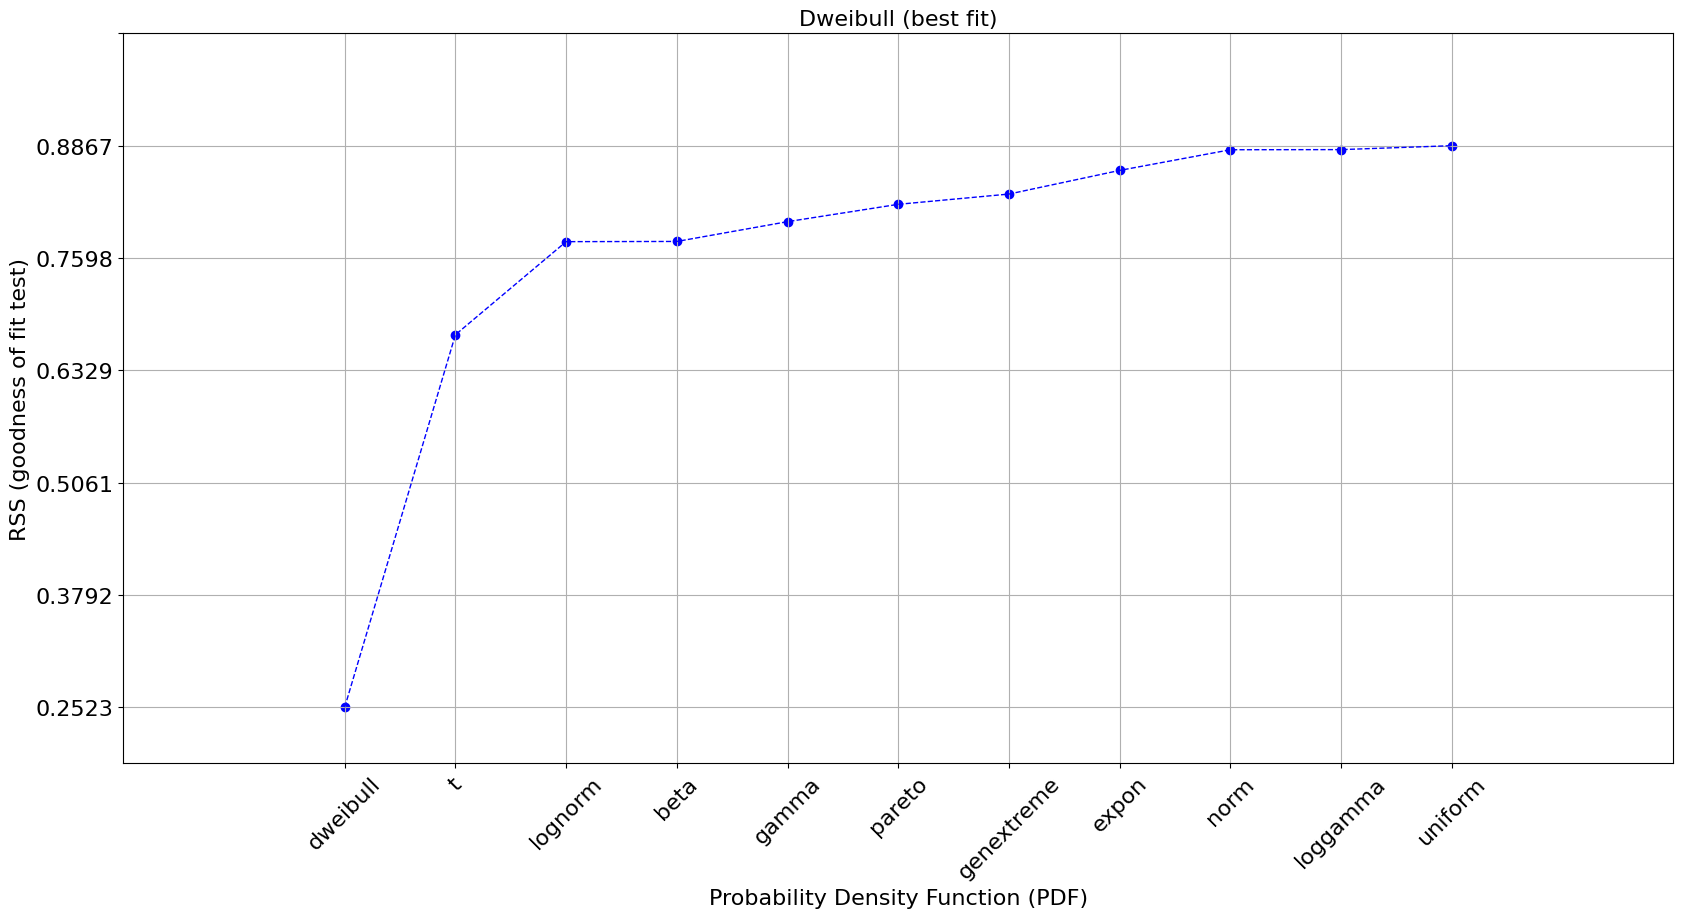

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Dweibull(loc:9.000000, scale:37.845066)


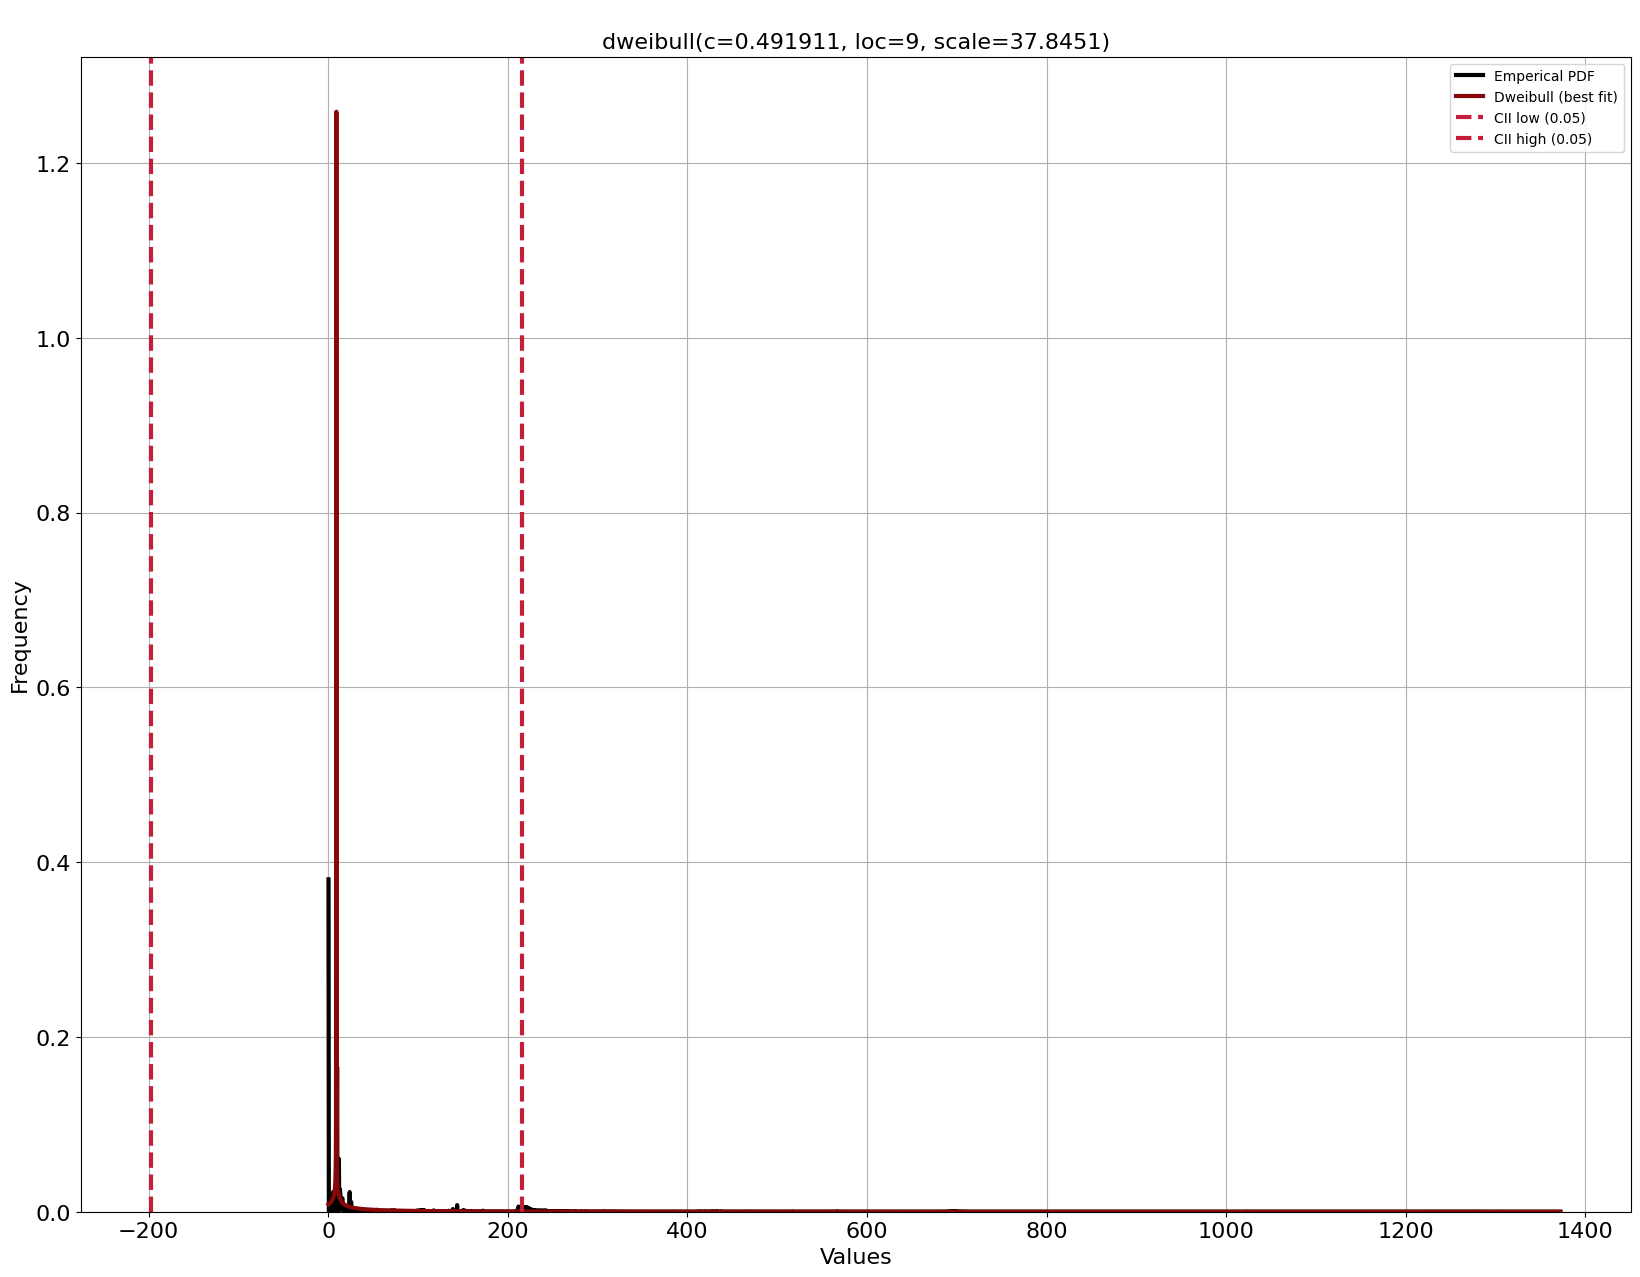

In [34]:
dfit.plot_summary()
plt.show()
dfit.plot(chart="pdf")
plt.show()

In [35]:
dfit_nz = distfit(todf=True)

# Fit the responder bytes per packet
resp_dfit_nz = dfit_nz.fit_transform(resp_bytes_per_pkt_nz)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0912855] [loc=93.084 scale=205.268]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0864914] [loc=0.091 scale=92.993]
[distfit] >INFO> [pareto    ] [0.10 sec] [RSS: 0.082093] [loc=-18.209 scale=18.300]
[distfit] >INFO> [dweibull  ] [8.64 sec] [RSS: 0.0710554] [loc=9.000 scale=52.594]
[distfit] >INFO> [t         ] [15.9 sec] [RSS: 0.0928166] [loc=9.000 scale=0.000]
[distfit] >INFO> [genextreme] [14.3 sec] [RSS: 0.0702248] [loc=12.922 scale=11.757]
[distfit] >INFO> [gamma     ] [3.58 sec] [RSS: 0.0875938] [loc=0.091 scale=507.621]
[distfit] >INFO> [lognorm   ] [4.40 sec] [RSS: 0.0794339] [loc=0.091 scale=23.675]
[distfit] >INFO> [beta      ] [7.46 sec] [RSS: 0.087171] [loc=0.091 scale=2607.172]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0923435] [loc=0.091 scale=1372.433]
[distfit] >INFO> [loggamma  ] [3.12 sec] [RSS: 0.0913456] [loc=-71131.693 scale=9458.238]
[distfit] >INFO> Compute 

[distfit] >INFO> Ploting Summary.


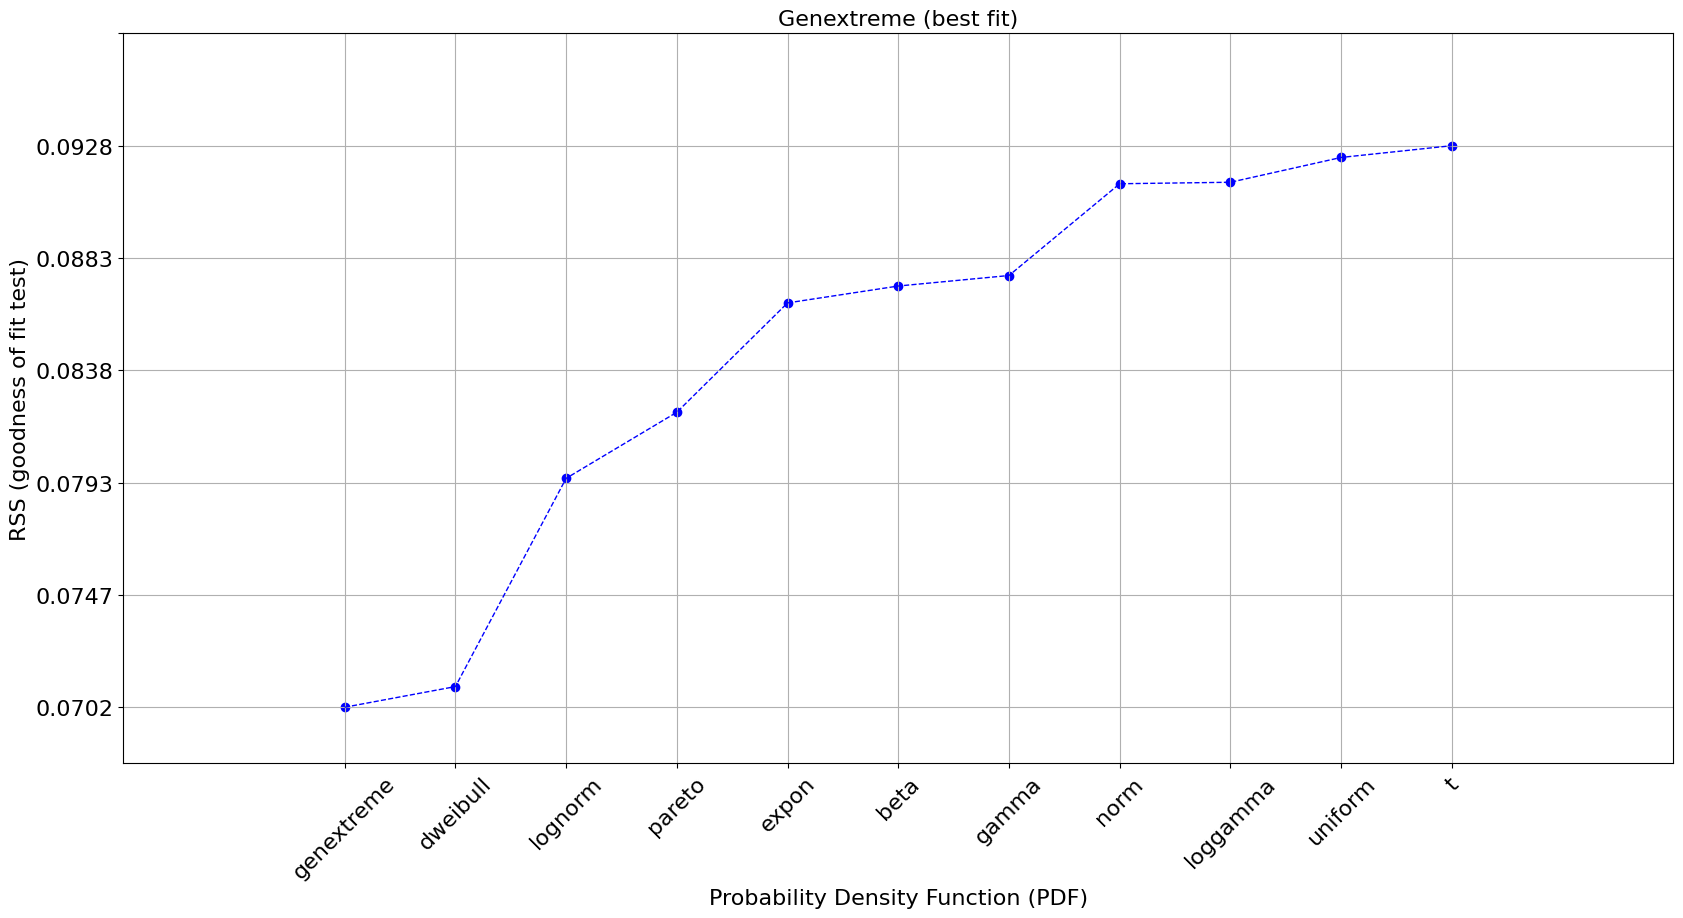

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Genextreme(loc:12.922165, scale:11.757182)


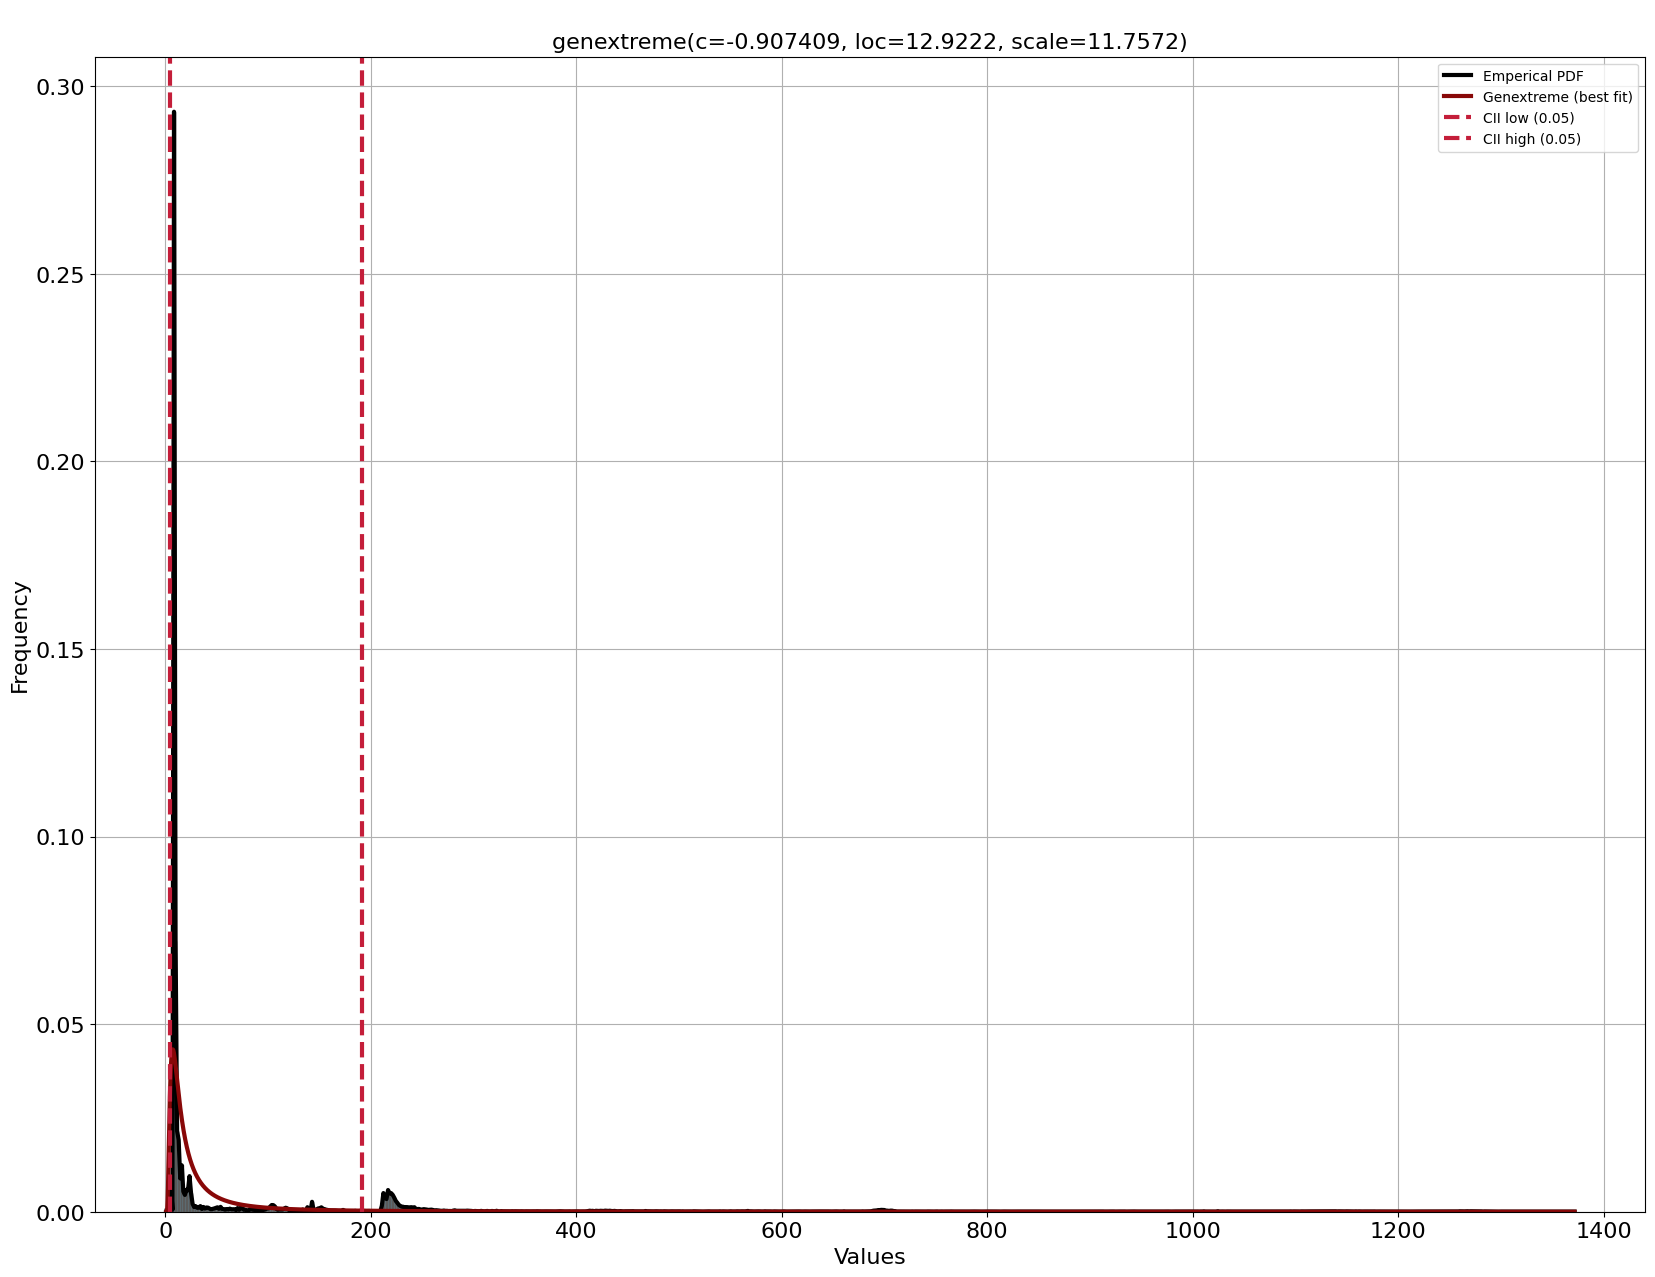

In [36]:
dfit_nz.plot_summary()
plt.show()
dfit_nz.plot(chart="pdf")
plt.show()

In [37]:
# from scipy.stats import truncnorm
# lower_bound = 0
# upper_bound = np.inf
# orig_bytes_per_pkt_trunc_norm_dist = truncnorm(
#     (lower_bound - orig_bytes_per_pkt_mu) / orig_bytes_per_pkt_std,
#     (upper_bound - orig_bytes_per_pkt_mu) / orig_bytes_per_pkt_std,
#     loc=orig_bytes_per_pkt_mu,
#     scale=orig_bytes_per_pkt_std,
# )
# num_samples = 1000  # Set the number of samples you want to generate
# orig_bytes_per_pkt_samples = orig_bytes_per_pkt_trunc_norm_dist.rvs(num_samples)
# orig_bytes_per_pkt_samples.astype(int)

### Pareto distribution

Pareto distribution parameters for responder bytes per packet: (0.7891188117505623, -8.42743386762661, 8.427433867626608)
Pareto distribution parameters for responder bytes per packet non zero values: (0.962759499791336, -18.20899651137831, 18.2999056022874)


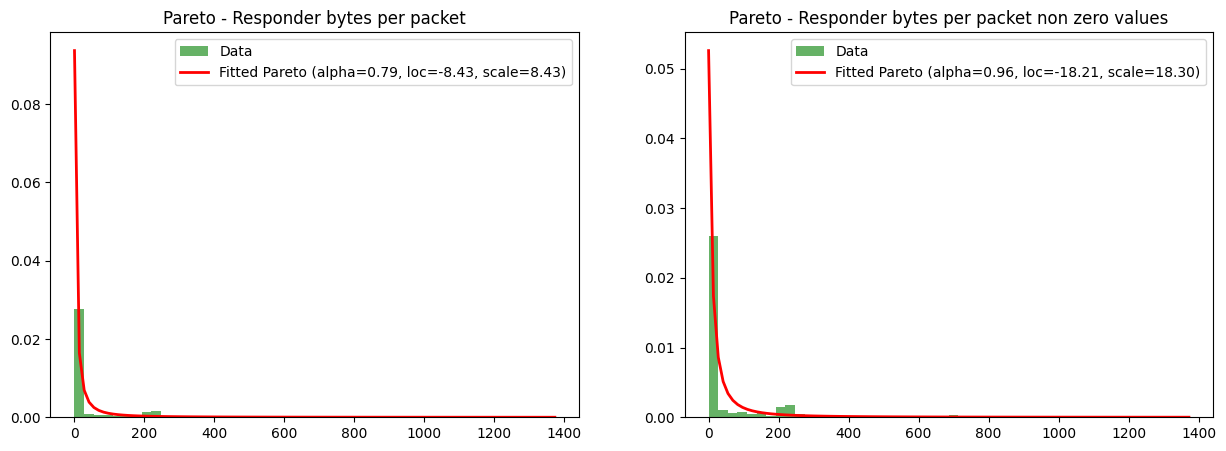

Pareto distribution parameters for originator bytes per packet: (2.7640998131874914, -80.83648611550106, 80.83648611550105)
Pareto distribution parameters for originator bytes per packet non zero values: (4.510929391269413, -177.4094796655702, 177.41237841634663)


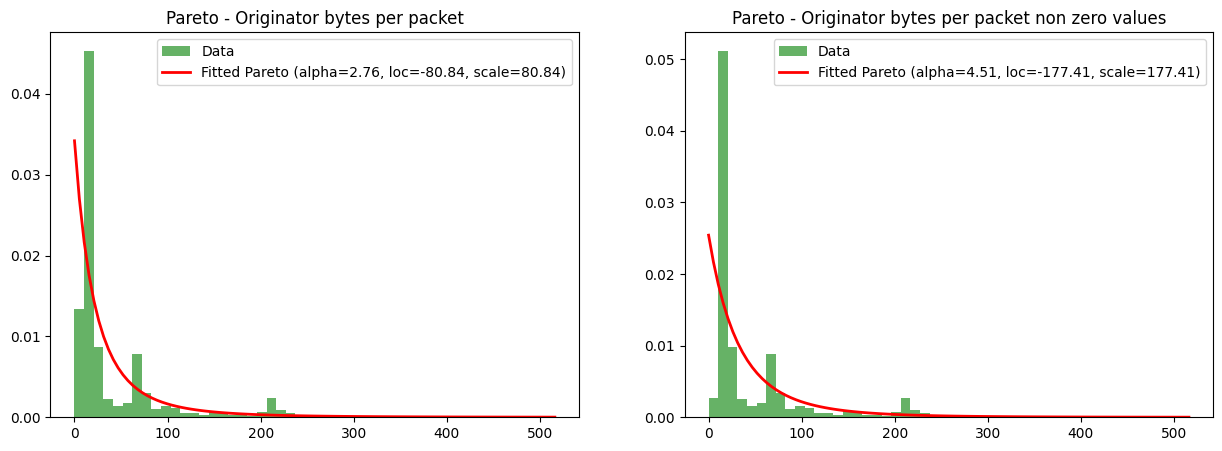

In [13]:
from scipy.stats import pareto

# Fit a Pareto distribution to the responder bytes per packet
resp_pareto_dist = pareto.fit(resp_bytes_per_pkt)
print("Pareto distribution parameters for responder bytes per packet: {}".format(resp_pareto_dist))
# Fit a Pareto distribution to the responder bytes per packet non zero values
resp_pareto_dist_nz = pareto.fit(resp_bytes_per_pkt_nz)
print("Pareto distribution parameters for responder bytes per packet non zero values: {}".format(resp_pareto_dist_nz))

# Plot the pareto distributions over the data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(resp_bytes_per_pkt, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(resp_bytes_per_pkt), np.max(resp_bytes_per_pkt), 100)
fitted_pdf = pareto.pdf(x, resp_pareto_dist[0], resp_pareto_dist[1], resp_pareto_dist[2])
ax1.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Pareto (alpha={resp_pareto_dist[0]:.2f}, loc={resp_pareto_dist[1]:.2f}, scale={resp_pareto_dist[2]:.2f})')
ax1.set_title("Pareto - Responder bytes per packet")
ax1.legend()
ax2.hist(resp_bytes_per_pkt_nz, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(resp_bytes_per_pkt_nz), np.max(resp_bytes_per_pkt_nz), 100)
fitted_pdf = pareto.pdf(x, resp_pareto_dist_nz[0], resp_pareto_dist_nz[1], resp_pareto_dist_nz[2])
ax2.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Pareto (alpha={resp_pareto_dist_nz[0]:.2f}, loc={resp_pareto_dist_nz[1]:.2f}, scale={resp_pareto_dist_nz[2]:.2f})')
ax2.set_title("Pareto - Responder bytes per packet non zero values")
ax2.legend()
plt.show()

# Fit a Pareto distribution to the originator bytes per packet
orig_pareto_dist = pareto.fit(orig_bytes_per_pkt)
print("Pareto distribution parameters for originator bytes per packet: {}".format(orig_pareto_dist))
# Fit a Pareto distribution to the originator bytes per packet non zero values
orig_pareto_dist_nz = pareto.fit(orig_bytes_per_pkt_nz)
print("Pareto distribution parameters for originator bytes per packet non zero values: {}".format(orig_pareto_dist_nz))

# Plot the pareto distributions over the data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(orig_bytes_per_pkt, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(orig_bytes_per_pkt), np.max(orig_bytes_per_pkt), 100)
fitted_pdf = pareto.pdf(x, orig_pareto_dist[0], orig_pareto_dist[1], orig_pareto_dist[2])
ax1.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Pareto (alpha={orig_pareto_dist[0]:.2f}, loc={orig_pareto_dist[1]:.2f}, scale={orig_pareto_dist[2]:.2f})')
ax1.set_title("Pareto - Originator bytes per packet")
ax1.legend()
ax2.hist(orig_bytes_per_pkt_nz, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(orig_bytes_per_pkt_nz), np.max(orig_bytes_per_pkt_nz), 100)
fitted_pdf = pareto.pdf(x, orig_pareto_dist_nz[0], orig_pareto_dist_nz[1], orig_pareto_dist_nz[2])
ax2.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Pareto (alpha={orig_pareto_dist_nz[0]:.2f}, loc={orig_pareto_dist_nz[1]:.2f}, scale={orig_pareto_dist_nz[2]:.2f})')
ax2.set_title("Pareto - Originator bytes per packet non zero values")
ax2.legend()
plt.show()

In [14]:
#  Perform a KS test to see if the data is consistent with the fitted distribution
from scipy.stats import kstest

# Estimate the parameters of the Pareto distribution
orig_pareto_dist_shape, orig_pareto_dist_loc, orig_pareto_dist_scale = orig_pareto_dist
# Perform the K-S test
D, p_value = kstest(resp_bytes_per_pkt, 'pareto', args=(orig_pareto_dist_shape, orig_pareto_dist_loc, orig_pareto_dist_scale))
print(f"Resp K-S test statistic: {D}")
print(f"Resp p-value: {p_value}")

orig_pareto_dist_nz_shape, orig_pareto_dist_nz_loc, orig_pareto_dist_nz_scale = orig_pareto_dist_nz
# Perform the K-S test
D, p_value = kstest(resp_bytes_per_pkt_nz, 'pareto', args=(orig_pareto_dist_nz_shape, orig_pareto_dist_nz_loc, orig_pareto_dist_nz_scale))
print(f"Resp non zero K-S test statistic: {D}")
print(f"Resp non zero p-value: {p_value}")

# Estimate the parameters of the Pareto distribution
resp_pareto_dist_shape, resp_pareto_dist_loc, resp_pareto_dist_scale = resp_pareto_dist
# Perform the K-S test
D, p_value = kstest(orig_bytes_per_pkt, 'pareto', args=(resp_pareto_dist_shape, resp_pareto_dist_loc, resp_pareto_dist_scale))
print(f"Orig K-S test statistic: {D}")
print(f"Orig p-value: {p_value}")

resp_pareto_dist_nz_shape, resp_pareto_dist_nz_loc, resp_pareto_dist_nz_scale = resp_pareto_dist_nz
# Perform the K-S test
D, p_value = kstest(orig_bytes_per_pkt_nz, 'pareto', args=(resp_pareto_dist_nz_shape, resp_pareto_dist_nz_loc, resp_pareto_dist_nz_scale))
print(f"Orig non zero K-S test statistic: {D}")
print(f"Orig non zero p-value: {p_value}")


Resp K-S test statistic: 0.35151095126216914
Resp p-value: 0.0
Resp non zero K-S test statistic: 0.3434694167456315
Resp non zero p-value: 0.0
Orig K-S test statistic: 0.39636555275841967
Orig p-value: 0.0
Orig non zero K-S test statistic: 0.38781470982453403
Orig non zero p-value: 0.0


In [15]:
# Perfrorm the AD goodness of fit test on the Pareto distributions
from scipy.stats import goodness_of_fit

res = goodness_of_fit(pareto, orig_bytes_per_pkt, n_mc_samples=10)
print("\nOriginator", res)

res = goodness_of_fit(pareto, orig_bytes_per_pkt_nz, n_mc_samples=10)
print("\nOriginator non zero", res)

res = goodness_of_fit(pareto, resp_bytes_per_pkt, n_mc_samples=10)
print("\nResponder", res)

res = goodness_of_fit(pareto, resp_bytes_per_pkt_nz, n_mc_samples=10)
print("\nResponder non zero", res)


Originator GoodnessOfFitResult(fit_result=  params: FitParams(b=2.7640998131874914, loc=-80.83648611550106, scale=80.83648611550105)
 success: True
 message: 'The fit was performed successfully.', statistic=208008.19341513223, pvalue=0.09090909090909091, null_distribution=array([0.19838015, 0.25907071, 0.22755244, 0.42273609, 0.61877935,
       0.27706294, 0.47167485, 0.51026552, 0.2073955 , 0.25373043]))

Originator non zero GoodnessOfFitResult(fit_result=  params: FitParams(b=4.510929391269413, loc=-177.4094796655702, scale=177.41237841634663)
 success: True
 message: 'The fit was performed successfully.', statistic=inf, pvalue=0.09090909090909091, null_distribution=array([0.96440655, 0.48301777, 0.64613325, 0.454595  , 0.44628223,
       0.28189854, 0.34420593, 0.41923696, 0.46309031, 0.34006208]))

Responder GoodnessOfFitResult(fit_result=  params: FitParams(b=0.7891188117505623, loc=-8.42743386762661, scale=8.427433867626608)
 success: True
 message: 'The fit was performed succes

### Weibull distribution

Double Weibull distribution parameters for responder bytes per packet: (0.49191072740102026, 9.000000000000004, 37.845066475465245)
Double Weibull distribution parameters for responder bytes per packet non zero values: (0.5899527877181552, 8.999999999999998, 52.594233623448964)


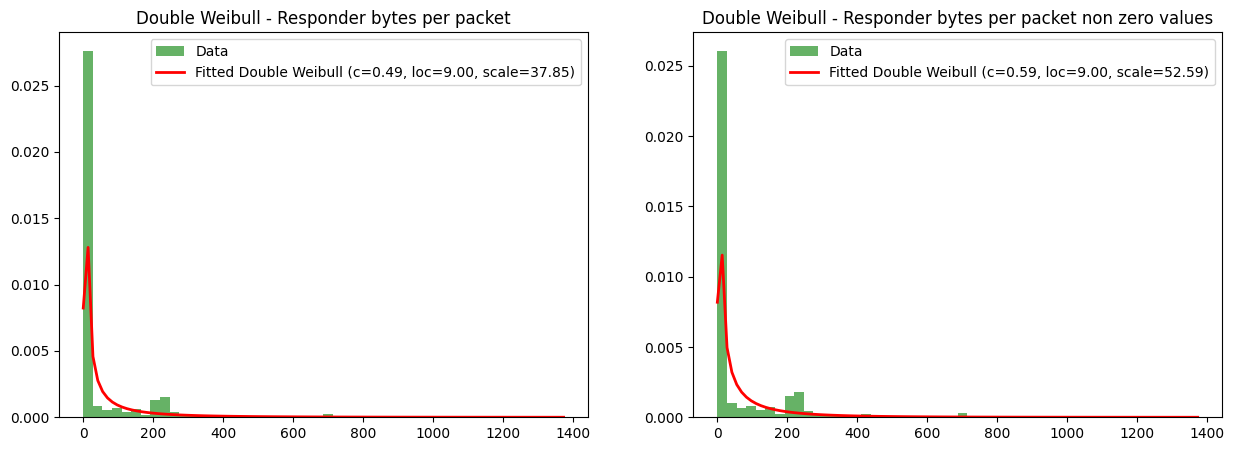

Double Weibull distribution parameters for originator bytes per packet: (0.47373845131670356, 16.500000000000007, 54.890585354805275)
Double Weibull distribution parameters for originator bytes per packet non zero values: (0.46373059457733756, 17.000000000000007, 15.449740146040487)


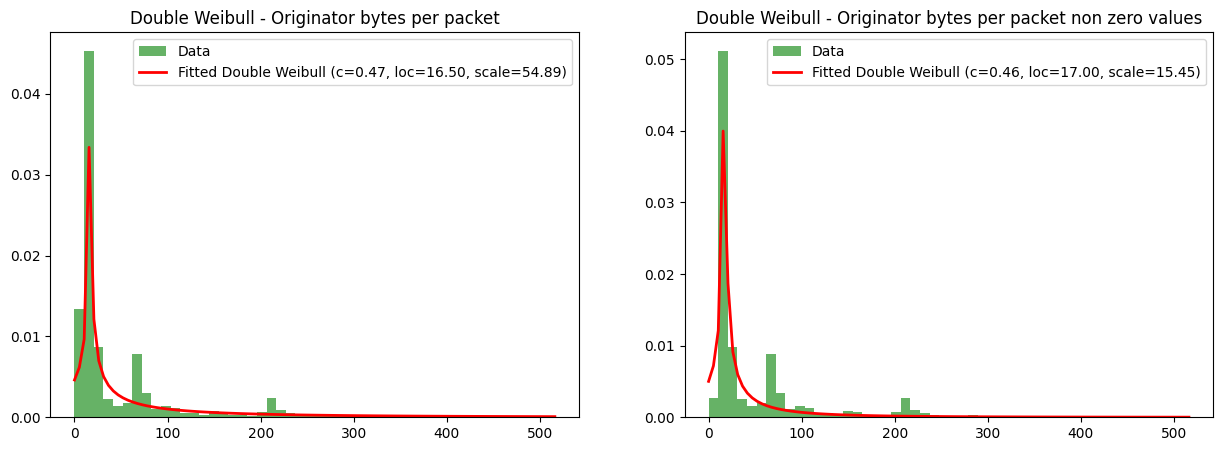

In [16]:
# Fit a Double Weibull distribution to the data
from scipy.stats import dweibull

# Fit a Double Weibull distribution to the responder bytes per packet
resp_dweibull_dist = dweibull.fit(resp_bytes_per_pkt)
print("Double Weibull distribution parameters for responder bytes per packet: {}".format(resp_dweibull_dist))
# Fit a Double Weibull distribution to the responder bytes per packet non zero values
resp_dweibull_dist_nz = dweibull.fit(resp_bytes_per_pkt_nz)
print("Double Weibull distribution parameters for responder bytes per packet non zero values: {}".format(resp_dweibull_dist_nz))

# Plot the Double Weibull distributions over the data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(resp_bytes_per_pkt, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(resp_bytes_per_pkt), np.max(resp_bytes_per_pkt), 100)
fitted_pdf = dweibull.pdf(x, resp_dweibull_dist[0], resp_dweibull_dist[1], resp_dweibull_dist[2])
ax1.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Double Weibull (c={resp_dweibull_dist[0]:.2f}, loc={resp_dweibull_dist[1]:.2f}, scale={resp_dweibull_dist[2]:.2f})')
ax1.set_title("Double Weibull - Responder bytes per packet")
ax1.legend()
ax2.hist(resp_bytes_per_pkt_nz, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(resp_bytes_per_pkt_nz), np.max(resp_bytes_per_pkt_nz), 100)
fitted_pdf = dweibull.pdf(x, resp_dweibull_dist_nz[0], resp_dweibull_dist_nz[1], resp_dweibull_dist_nz[2])
ax2.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Double Weibull (c={resp_dweibull_dist_nz[0]:.2f}, loc={resp_dweibull_dist_nz[1]:.2f}, scale={resp_dweibull_dist_nz[2]:.2f})')
ax2.set_title("Double Weibull - Responder bytes per packet non zero values")
ax2.legend()
plt.show()

# Fit a Double Weibull distribution to the originator bytes per packet
orig_dweibull_dist = dweibull.fit(orig_bytes_per_pkt)
print("Double Weibull distribution parameters for originator bytes per packet: {}".format(orig_dweibull_dist))
# Fit a Double Weibull distribution to the originator bytes per packet non zero values
orig_dweibull_dist_nz = dweibull.fit(orig_bytes_per_pkt_nz)
print("Double Weibull distribution parameters for originator bytes per packet non zero values: {}".format(orig_dweibull_dist_nz))

# Plot the Double Weibull distributions over the data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(orig_bytes_per_pkt, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(orig_bytes_per_pkt), np.max(orig_bytes_per_pkt), 100)
fitted_pdf = dweibull.pdf(x, orig_dweibull_dist[0], orig_dweibull_dist[1], orig_dweibull_dist[2])
ax1.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Double Weibull (c={orig_dweibull_dist[0]:.2f}, loc={orig_dweibull_dist[1]:.2f}, scale={orig_dweibull_dist[2]:.2f})')
ax1.set_title("Double Weibull - Originator bytes per packet")
ax1.legend()
ax2.hist(orig_bytes_per_pkt_nz, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(np.min(orig_bytes_per_pkt_nz), np.max(orig_bytes_per_pkt_nz), 100)
fitted_pdf = dweibull.pdf(x, orig_dweibull_dist_nz[0], orig_dweibull_dist_nz[1], orig_dweibull_dist_nz[2])
ax2.plot(x, fitted_pdf, 'r', linewidth=2, label=f'Fitted Double Weibull (c={orig_dweibull_dist_nz[0]:.2f}, loc={orig_dweibull_dist_nz[1]:.2f}, scale={orig_dweibull_dist_nz[2]:.2f})')
ax2.set_title("Double Weibull - Originator bytes per packet non zero values")
ax2.legend()
plt.show()


In [17]:
# Perform the K-S test
D, p_value = kstest(resp_bytes_per_pkt, 'dweibull', args=(resp_dweibull_dist[0], resp_dweibull_dist[1], resp_dweibull_dist[2]))
print(f"Resp K-S test statistic: {D}")
print(f"Resp p-value: {p_value}")
D, p_value = kstest(resp_bytes_per_pkt_nz, 'dweibull', args=(resp_dweibull_dist_nz[0], resp_dweibull_dist_nz[1], resp_dweibull_dist_nz[2]))
print(f"Resp K-S test statistic: {D}")
print(f"Resp p-value: {p_value}")
D, p_value = kstest(orig_bytes_per_pkt, 'dweibull', args=(orig_dweibull_dist[0], orig_dweibull_dist[1], orig_dweibull_dist[2]))
print(f"Orig K-S test statistic: {D}")
print(f"Orig p-value: {p_value}")
D, p_value = kstest(orig_bytes_per_pkt_nz, 'dweibull', args=(orig_dweibull_dist_nz[0], orig_dweibull_dist_nz[1], orig_dweibull_dist_nz[2]))
print(f"Orig K-S test statistic: {D}")
print(f"Orig p-value: {p_value}")


Resp K-S test statistic: 0.305286231241109
Resp p-value: 0.0
Resp K-S test statistic: 0.4562185941555443
Resp p-value: 0.0
Orig K-S test statistic: 0.283938395527081
Orig p-value: 0.0
Orig K-S test statistic: 0.29061339013211573
Orig p-value: 0.0


In [41]:
resp_pareto_dist_nz

(0.962759499791336, -18.20899651137831, 18.2999056022874)

In [42]:
# Sample from the double weibull distribution 
resp_dweibull_samples = dweibull.rvs(resp_dweibull_dist_nz[0], resp_dweibull_dist_nz[1], resp_dweibull_dist_nz[2], size=1000000)
orig_dweibull_samples = dweibull.rvs(orig_dweibull_dist_nz[0], orig_dweibull_dist_nz[1], orig_dweibull_dist_nz[2], size=1000000)

# Sample from the pareto distribution
resp_pareto_samples = pareto.rvs(resp_pareto_dist_nz[0], resp_pareto_dist_nz[1], resp_pareto_dist_nz[2], size=1000000)
orig_pareto_samples = pareto.rvs(orig_pareto_dist_nz[0], orig_pareto_dist_nz[1], resp_pareto_dist_nz[2], size=1000000)

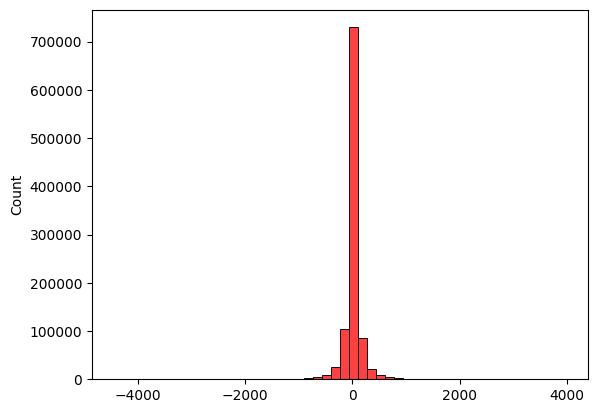

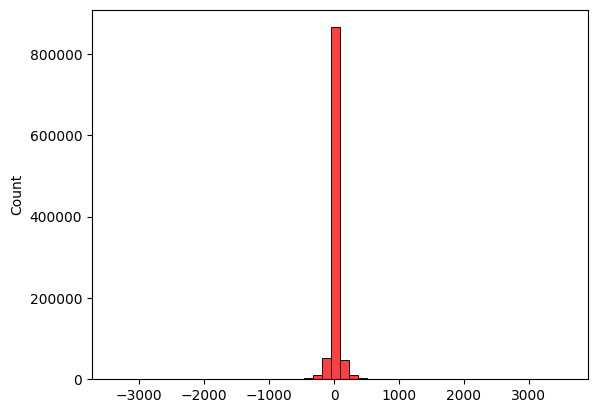

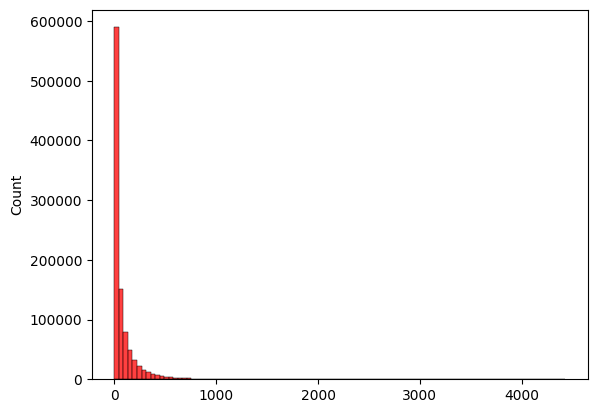

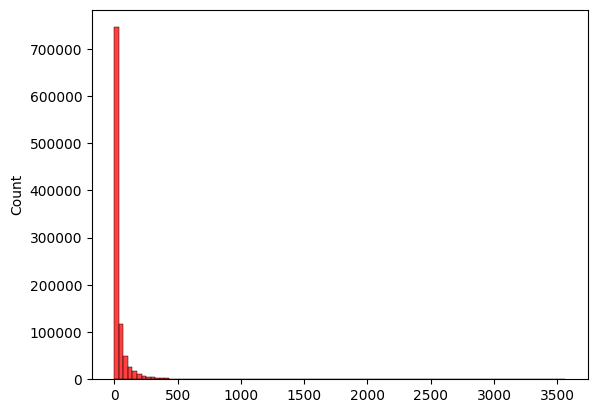

In [43]:
sns.histplot(resp_dweibull_samples, bins=50, stat='count', kde=False, color='r', label='Double Weibull')
plt.show()
sns.histplot(orig_dweibull_samples, bins=50, stat='count', kde=False, color='r', label='Double Weibull')
plt.show()
sns.histplot(np.abs(resp_dweibull_samples), bins=100, stat='count', kde=False, color='r', label='Double Weibull')
plt.show()
sns.histplot(np.abs(orig_dweibull_samples), bins=100, stat='count', kde=False, color='r', label='Double Weibull')
plt.show()

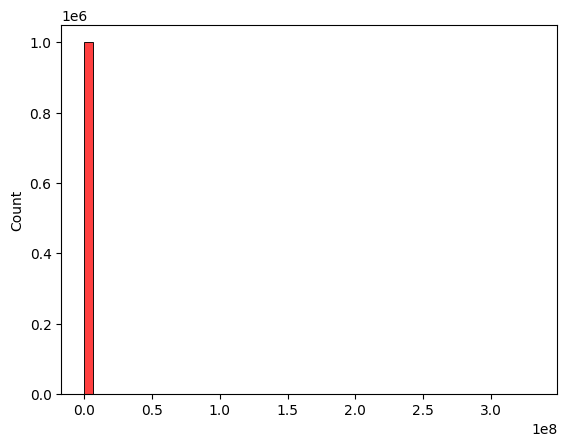

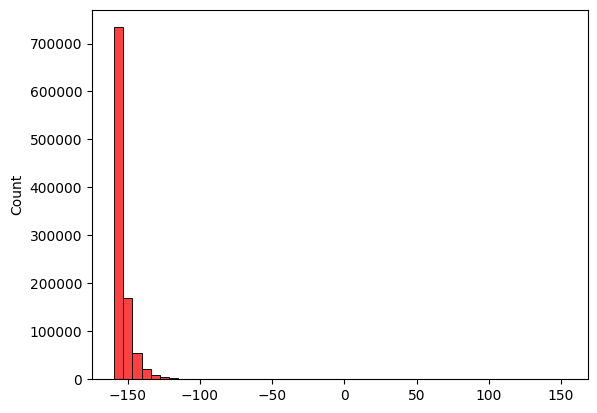

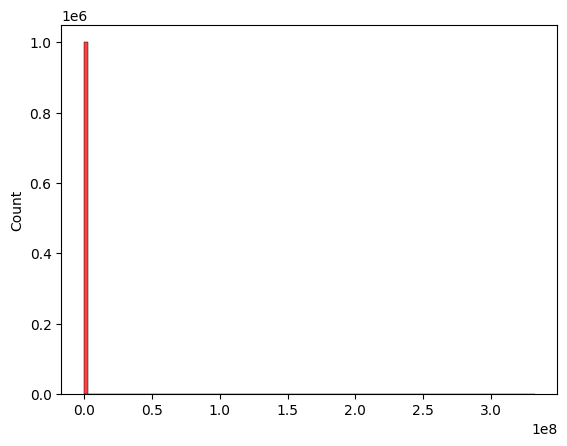

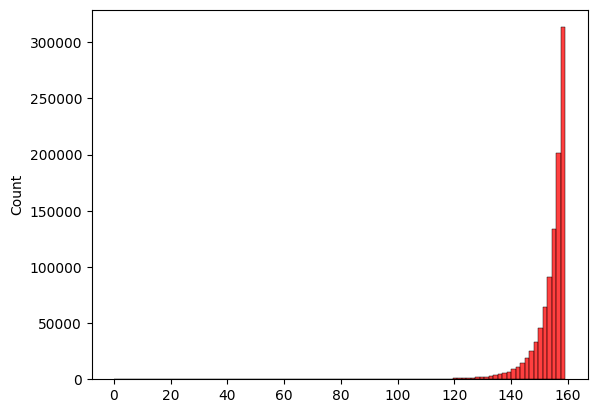

In [44]:
sns.histplot(resp_pareto_samples, bins=50, stat='count', kde=False, color='r', label='Pareto')
plt.show()
sns.histplot(orig_pareto_samples, bins=50, stat='count', kde=False, color='r', label='Pareto')
plt.show()
sns.histplot(np.abs(resp_pareto_samples), bins=100, stat='count', kde=False, color='r', label='Pareto')
plt.show()
sns.histplot(np.abs(orig_pareto_samples), bins=100, stat='count', kde=False, color='r', label='Pareto')
plt.show()

<AxesSubplot: ylabel='Count'>

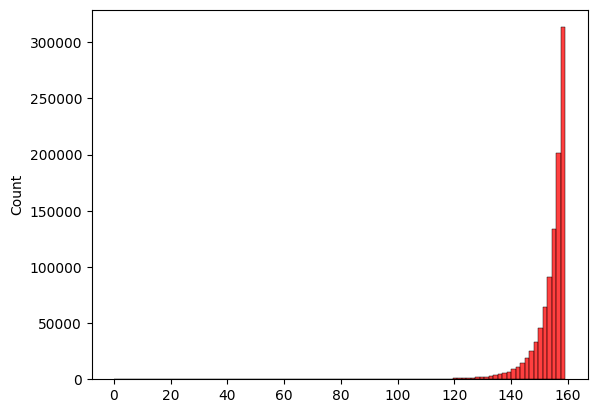

In [45]:
sns.histplot(np.abs(orig_pareto_samples), bins=100, stat='count', kde=False, color='r', label='Pareto')


## Original conn.log

In [ ]:
conn_log_1_42_pth = "/net/data/netpois/ctu-13/1_42/bro/conn.log"
conn_log_2_43_pth = "/net/data/netpois/ctu-13/2_43/bro/conn.log"
conn_log_9_50_pth = "/net/data/netpois/ctu-13/9_50/bro/conn.log"

In [ ]:
def read_conn_log_file(fpath):
    conn_log = open(fpath, "r").readlines()
    sep = "\t"
    cols = conn_log[6].split("#fields")[1].strip().split(sep)
    conn_log = conn_log[8:-1]

    conn_log_df = pd.read_table(
        io.StringIO('\n'.join(conn_log)),
        sep=sep,
        names=cols,
    )
    return conn_log_df

In [ ]:
# np.unique(conn_log_1_42_df[conn_log_1_42_df["orig_bytes"] == 0]["orig_pkts"], return_counts=True)

In [ ]:
# print("Total cols", list(conn_log_1_42_df.columns))
# print("Used cols", list(conn_log_1_42.columns))

resp_p -> service
service -> proto
proto -> conn_state
conn_state -> orig_pkts, resp_pkts
orig_pkts -> orig_bytes   |    resp_pkts -> resp_bytes    |    proto, orig_pkts, resp_pkts -> duration

id.orig_p -- whatevs
orig_pkts and resp_pkts should not have a direct dependency


In [ ]:
conn_log_1_42_df = read_conn_log_file(conn_log_1_42_pth)
display(conn_log_1_42_df)

In [ ]:
conn_log_2_43_df = read_conn_log_file(conn_log_2_43_pth)
display(conn_log_2_43_df)

In [ ]:
conn_log_1_42_most_common_hist = Counter(conn_log_1_42_df["history"])
display(conn_log_1_42_most_common_hist.most_common(20)) 

In [ ]:
conn_log_2_43_most_common_hist = Counter(conn_log_2_43_df["history"])
display(conn_log_2_43_most_common_hist.most_common(20)) 

In [ ]:
print(np.unique(conn_log_1_42_df[conn_log_1_42_df["history"] == "Dd"]["proto"], return_counts=True))
print(np.unique(conn_log_2_43_df[conn_log_2_43_df["history"] == "Dd"]["proto"], return_counts=True))

In [ ]:
print(np.unique(conn_log_1_42_df[conn_log_1_42_df["proto"] == "udp"]["history"], return_counts=True))
print(np.unique(conn_log_2_43_df[conn_log_2_43_df["proto"] == "udp"]["history"], return_counts=True))

## Models

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_type = "FFNN"
model_types = ["GradientBoosting", "FFNN"]
scenario_tag = constants.neris_tag
scenario_ind = 1

In [12]:

# for scenario_ind in range(3):
#     # Load the model and data
#     model, x_train, y_train, x_test, y_test, columns = utils.load_ctu13_data_and_model(
#         model_type, scenario_tag, scenario_ind
#     )

#     # Get the predictions
#     y_pred = model.predict(x_test)
    
#     # Print the metrics
#     print("Scenario {}".format(scenario_ind))
#     print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
#     print("Precision: {}".format(precision_score(y_test, y_pred)))
#     print("Recall: {}".format(recall_score(y_test, y_pred)))
#     print("F1: {}".format(f1_score(y_test, y_pred)))
#     print()

In [13]:
from netpois import data_utils

In [14]:
train_captures = constants.subscenarios[scenario_tag]["train"][scenario_ind]
test_captures = constants.subscenarios[scenario_tag]["test"][scenario_ind]

In [15]:
cl_1_42 = conn_log_1_42
cl_2_43 = conn_log_2_43
cl_9_50 = conn_log_9_50
all_cl = {"1_42": cl_1_42, "2_43": cl_2_43, "9_50": cl_9_50}

train_conn_logs = {capture: all_cl[capture] for capture in train_captures}
test_conn_logs = {capture: all_cl[capture] for capture in test_captures}

print("Shape 1_42: {}".format(cl_1_42.shape))
print("Shape 2_43: {}".format(cl_2_43.shape))
print("Shape 9_50: {}".format(cl_9_50.shape))
print("Train conn logs: {}".format(train_conn_logs.keys()))
print("Test conn logs: {}".format(test_conn_logs.keys()))

# Extract aggregated features from the conn.log files
df_1_42, labels_1_42, rows_1_42 = data_utils.process_zeek_csv(
    cl_1_42,
    internal_prefixes=data_utils.ds_internal_prefixes[scenario_tag],
    attacker_ips=data_utils.ds_attacker_ips[scenario_tag]["1_42"],
    t_window=30,
)
print("1_42 shape: {}".format(df_1_42.shape))
print("1_42 labels: {}".format(labels_1_42.shape))
print("1_42 labels: {}".format(np.unique(labels_1_42, return_counts=True)))
print("1_42 rows: {}".format(rows_1_42.shape))
df_2_43, labels_2_43, rows_2_43 = data_utils.process_zeek_csv(
    cl_2_43,
    internal_prefixes=data_utils.ds_internal_prefixes[scenario_tag],
    attacker_ips=data_utils.ds_attacker_ips[scenario_tag]["2_43"],
    t_window=30,
)
print("2_43 shape: {}".format(df_2_43.shape))
print("2_43 labels: {}".format(labels_2_43.shape))
print("2_43 labels: {}".format(np.unique(labels_2_43, return_counts=True)))
print("2_43 rows: {}".format(rows_2_43.shape))
df_9_50, labels_9_50, rows_9_50 = data_utils.process_zeek_csv(
    cl_9_50,
    internal_prefixes=data_utils.ds_internal_prefixes[scenario_tag],
    attacker_ips=data_utils.ds_attacker_ips[scenario_tag]["9_50"],
    t_window=30,
)
print("9_50 shape: {}".format(df_9_50.shape))
print("9_50 labels: {}".format(labels_9_50.shape))
print("9_50 labels: {}".format(np.unique(labels_9_50, return_counts=True)))
print("9_50 rows: {}".format(rows_9_50.shape))

assert np.array_equal(df_1_42.columns.to_numpy(), df_2_43.columns.to_numpy())
assert np.array_equal(df_1_42.columns.to_numpy(), df_9_50.columns.to_numpy())

all_df = {"1_42": df_1_42, "2_43": df_2_43, "9_50": df_9_50}
all_labels = {"1_42": labels_1_42, "2_43": labels_2_43, "9_50": labels_9_50}
all_rows = {"1_42": rows_1_42, "2_43": rows_2_43, "9_50": rows_9_50}

Shape 1_42: (4070899, 14)
Shape 2_43: (2565282, 14)
Shape 9_50: (2625792, 14)
Train conn logs: dict_keys(['1_42', '9_50'])
Test conn logs: dict_keys(['2_43'])
Current conn log shape: (4070899, 14)
Added orig_row column: (4070899, 15)
Removed NaN values: (4070899, 15)
Removed IPV6 addresses: (4070379, 15)
Removed external connections: (4062992, 15)
Removed internal connections: (3098330, 15)
src_df shape:  (987607, 21)
dst_df shape:  (2110723, 21)
src_agg shape:  (68528, 37)
dst_agg shape:  (43016, 37)
1_42 shape: (77183, 1152)
1_42 labels: (77183,)
1_42 labels: (array([0, 1]), array([76614,   569]))
1_42 rows: (77183,)
Current conn log shape: (2565282, 14)
Added orig_row column: (2565282, 15)
Removed NaN values: (2565282, 15)
Removed IPV6 addresses: (2564941, 15)
Removed external connections: (2559794, 15)
Removed internal connections: (1912000, 15)
src_df shape:  (622714, 21)
dst_df shape:  (1289286, 21)
src_agg shape:  (54133, 37)
dst_agg shape:  (26215, 37)
2_43 shape: (55082, 1152)

In [16]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

trn_accs = defaultdict(list)
trn_f1s = defaultdict(list)
trn_precs = defaultdict(list)
trn_recalls = defaultdict(list)
tst_accs = defaultdict(list)
tst_f1s = defaultdict(list)
tst_precs = defaultdict(list)
tst_recalls = defaultdict(list)

for seed in range(5):
    for model_type in model_types:

        orig_x_train = np.concatenate([all_df[tc].values for tc in train_captures])
        orig_y_train = np.concatenate([all_labels[tc] for tc in train_captures])
        orig_rows_train = np.concatenate([all_rows[tc] for tc in train_captures])
        orig_src_train = np.concatenate(
            [np.full(all_df[tc].shape[0], tc) for tc in train_captures]
        )

        # Test and adversarial datasets
        tst_cp = test_captures[0]  # There is only one test capture
        tst_indices, adv_indices, = train_test_split(
            np.arange(all_df[tst_cp].values.shape[0]),
            test_size=0.15,
            random_state=seed,
            stratify=all_labels[tst_cp],
        )
        tst_indices = np.sort(tst_indices)
        adv_indices = np.sort(adv_indices)
        orig_x_test = all_df[tst_cp].values[tst_indices]
        orig_y_test = all_labels[tst_cp][tst_indices]
        x_adv = all_df[tst_cp].values[adv_indices]
        y_adv = all_labels[tst_cp][adv_indices]

        orig_model = utils.train_model(
            model_type=model_type,
            x_trn=orig_x_train,
            y_trn=orig_y_train,
            save_pth=None,
            random_state=seed,
        )

        # Evaluate the original model
        orig_train_pred = orig_model.predict(orig_x_train)
        orig_test_pred = orig_model.predict(orig_x_test)

        orig_train_acc = accuracy_score(orig_y_train, orig_train_pred)
        orig_test_acc = accuracy_score(orig_y_test, orig_test_pred)
        orig_train_f1 = f1_score(orig_y_train, orig_train_pred)
        orig_test_f1 = f1_score(orig_y_test, orig_test_pred)
        orig_train_prec = precision_score(orig_y_train, orig_train_pred)
        orig_test_prec = precision_score(orig_y_test, orig_test_pred)
        orig_train_rec = recall_score(orig_y_train, orig_train_pred)
        orig_test_rec = recall_score(orig_y_test, orig_test_pred)
        
        trn_accs[model_type].append(orig_train_acc)
        trn_f1s[model_type].append(orig_train_f1)
        trn_precs[model_type].append(orig_train_prec)
        trn_recalls[model_type].append(orig_train_rec)
        
        tst_accs[model_type].append(orig_test_acc)
        tst_f1s[model_type].append(orig_test_f1)
        tst_precs[model_type].append(orig_test_prec)
        tst_recalls[model_type].append(orig_test_rec)


2023-05-23 12:30:55.146140: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-23 12:30:55.146218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: achtung-dome
2023-05-23 12:30:55.146229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: achtung-dome
2023-05-23 12:30:55.146452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-05-23 12:30:55.146507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.108.3
2023-05-23 12:30:55.146518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.108.3
2023-05-23 12:30:55.147019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
1118/1118 [==============================] - 9s 7ms/step - loss: 0.0172 - accuracy: 0.9967
Epoch 2/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0100 - accuracy: 0.9981
Epoch 3/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0095 - accuracy: 0.9982
Epoch 4/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0084 - accuracy: 0.9983
Epoch 5/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0081 - accuracy: 0.9984
Epoch 6/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0082 - accuracy: 0.9984
Epoch 7/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0078 - accuracy: 0.9984
Epoch 8/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0077 - accuracy: 0.9984
Epoch 9/10
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0072 - accuracy: 0.9985
Epoch 10/10
1464/1464 [==============================] - 3s 2ms/step
Epoch 1/10
11

In [17]:
print("Train Accuracies")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_accs[model_type])))
print("Train F1s")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_f1s[model_type])))
print("Train Precisions")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_precs[model_type])))
print("Train Recalls")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_recalls[model_type])))
print()
print("Test Accuracies")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_accs[model_type])))
print("Test F1s")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_f1s[model_type])))
print("Test Precisions")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_precs[model_type])))
print("Test Recalls")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_recalls[model_type])))



Train Accuracies
GradientBoosting: 0.9980174209694784
FFNN: 0.9985221537127916
Train F1s
GradientBoosting: 0.9573044498998927
FFNN: 0.9685867728075414
Train Precisions
GradientBoosting: 0.9996856134160804
FFNN: 0.9974375937473677
Train Recalls
GradientBoosting: 0.9183708838821489
FFNN: 0.941363373772386

Test Accuracies
GradientBoosting: 0.9994190392789252
FFNN: 0.9989662316580876
Test F1s
GradientBoosting: 0.9590540256523703
FFNN: 0.9269868413691503
Test Precisions
GradientBoosting: 0.9964179104477612
FFNN: 0.97059381984859
Test Recalls
GradientBoosting: 0.9248554913294796
FFNN: 0.8872832369942196
